## Processing the results after retraining and test of RO and ERO networks

In [1]:
"""
=================== Import required libraries ===================
"""

import csv
import ast
import os
import yaml
import pickle
import torch
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap


from pathlib import Path
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import sys
sys.path.append(r'C:\Users\hosseinifh\neuralhydrology') # In case of using VSC, this can help to activate and run libraries installed

from neuralhydrology.nh_run import start_run, Config
from neuralhydrology.evaluation import metrics, get_tester
from neuralhydrology.nh_run_scheduler import schedule_runs
from sklearn.model_selection import train_test_split
from pandas.plotting import parallel_coordinates
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid, ParameterSampler
from neuralhydrology.utils.nh_test_results_ensemble import create_test_results_ensemble


In [ ]:
"""
============= To load Config and modify it based on the choosen 8 best-performing HPs setups and 10 random seeds =============
            We will have 80 final HPs configurations to be trained (train+verification set) and tested (test set)
"""

# Define path to parameters list txt file
params_file = '...\final_8BestHPs.csv'

# Load hyperparameters from txt file
with open(params_file, 'r') as f:
    params_list = f.read().splitlines()

# Extract headers and parameter values
headers = params_list[0].split(',')
params = [line.split(',') for line in params_list[1:]]

# Load the original configuration file
config = yaml.load(Path("mtsLSTM_config.yml").read_text(), Loader=yaml.SafeLoader)

# Loop through each set of hyperparameters
for i, hyperparams in enumerate(params):
    try:
        # Convert non-integer values to floats
        hyperparams = [float(val) if '.' in val else int(val) if val != "" else None for val in hyperparams]

        # Update the config with the current set of hyperparameters
        for header, value in zip(headers, hyperparams):
            if value is None:
                 continue
            elif header == 'Seq_1D':
                config['seq_length']['1D'] = value
            elif header == 'Seq_1H':
                config['seq_length']['1H'] = value
            elif header == 'batch_size':
                config['batch_size'] = value
            elif header == 'target_noise_std':
                config['target_noise_std'] = value
            elif header == 'Lr0':
                config['learning_rate'][0] = value
            elif header == 'Lr10':
                config['learning_rate'][10] = value
            elif header == 'Lr25':
                config['learning_rate'][25] = value
            elif header == 'hidden_size':
                config['hidden_size'] = value
            elif header == 'output_dropout':
                config['output_dropout'] = value
            elif header == 'initial_forget_bias':
                config['initial_forget_bias'] = value
            elif header == 'loss':
                config['loss'] = value
            elif header == 'regularization':
                config['regularization'] = value
            else:
                raise ValueError('Unknown header:', header)

        # Create a new configuration file with a unique name based on the current set of hyperparameters
        config_file = Path(f"mtsLSTM_config_{i}.yml")

        # Write the updated configuration to the new file
        config_file.write_text(yaml.dump(config, default_flow_style=False))

    except Exception as e:
        print(f"Error occurred for hyperparameters {hyperparams}: {e}")
        continue  # continue to the next set of hyperparameters


In [ ]:
"""
============= To train 80 models on the (train+verification set) =============
"""
# Code to Run multiple train models in parallel

config_folder = Path("mtsLSTM_config_files")

# Set the mode, directory, GPU IDs, and runs per GPU
mode = "train"
directory = config_folder
gpu_ids = [0]  # List of GPU IDs to use
runs_per_gpu = 2 # Number of runs to start on a single GPU depending on the resources. We could not increase to more than 2 due to our coputational resources.

try:
    # Call the schedule_runs function
    schedule_runs(mode, directory, gpu_ids, runs_per_gpu)

except Exception as e:
    print(f"An error occurred during execution: {e}")


In [ ]:
"""
============= To load all Training Folders and Test them on test set =============
            We will have 80 final fully trained/tested models ensembles
"""

# Define the parent directory that contains the folders with config files
parent_dir_cluster = r".../runs/finalTrainTest"

for folder_name in os.listdir(parent_dir_cluster):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir_cluster, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        try:
            run_config_path = os.path.join(folder_path, "config.yml")

            # Load the config.yml file
            with open(run_config_path, 'r') as file:
                run_config = yaml.safe_load(file)

            # Create an instance of the Config class
            cfg = Config(run_config)

            # create a tester instance and start evaluation
            tester = get_tester(cfg=cfg, run_dir=Path(folder_path), period="test", init_model=True)
            results = tester.evaluate(save_results=True, metrics=cfg.metrics)

            results.keys()

            print("Folder name:", folder_name)
            print("Config file path:", run_config_path)

        except Exception as e:
            print(f"Error occurred for folder {folder_name}: {e}")
            continue  # continue to the next folder


In [ ]:
"""
================== Extract models simulations ==================
"""

# Define the parent directory that contains the folders with config files
parent_dir = r"D:\Experiments\Final80TrainedModels\Models"

for folder_name in os.listdir(parent_dir):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Set the directory for the results
        results_dir = folder_path

        # Read the basins list from the text file
        with open('URA40basins_list.txt', 'r') as file:
            basins_list = file.read().splitlines()

            # Load the pickle file
            pickle_file_path = Path(results_dir, "test", "model_epoch050", 'test_results.p')
            with open(pickle_file_path, 'rb') as pickle_file:
                test_results = pickle.load(pickle_file)

            # Create a new folder for saving the simulations
            simulations_dir = Path(results_dir, 'simulations')
            os.makedirs(simulations_dir, exist_ok=True)

            for basin in basins_list:
                # Extract observations and simulations
                basin_hourly_qsim_mean = test_results[basin]["1H"]["xr"]["streamflowmean_sim"]
                basin_daily_qsim_mean = test_results[basin]["1D"]["xr"]["streamflowmean_sim"]
                basin_hourly_qsim_inst = test_results[basin]["1H"]["xr"]["streamflowinst_sim"]
                basin_daily_qsim_inst = test_results[basin]["1D"]["xr"]["streamflowinst_sim"]
                basin_hourly_lsim_mean = test_results[basin]["1H"]["xr"]["levelmean_sim"]
                basin_daily_lsim_mean = test_results[basin]["1D"]["xr"]["levelmean_sim"]
                basin_hourly_lsim_inst = test_results[basin]["1H"]["xr"]["levelinst_sim"]
                basin_daily_lsim_inst = test_results[basin]["1D"]["xr"]["levelinst_sim"]

                # Define the filenames for saving data
                hourly_qsim_mean_filename = f'{basin}_qsim_mean_hourly.csv'
                daily_qsim_mean_filename = f'{basin}_qsim_mean_daily.csv'
                hourly_qsim_inst_filename = f'{basin}_qsim_inst_hourly.csv'
                daily_qsim_inst_filename = f'{basin}_qsim_inst_daily.csv'
                hourly_lsim_mean_filename = f'{basin}_lsim_mean_hourly.csv'
                daily_lsim_mean_filename = f'{basin}_lsim_mean_daily.csv'
                hourly_lsim_inst_filename = f'{basin}_lsim_inst_hourly.csv'
                daily_lsim_inst_filename = f'{basin}_lsim_inst_daily.csv'

                # Save data to CSV files
                pd.DataFrame(basin_hourly_qsim_mean.values).to_csv(os.path.join(simulations_dir, hourly_qsim_mean_filename), index=False)
                pd.DataFrame(basin_daily_qsim_mean.values).to_csv(os.path.join(simulations_dir, daily_qsim_mean_filename), index=False)
                pd.DataFrame(basin_hourly_qsim_inst.values).to_csv(os.path.join(simulations_dir, hourly_qsim_inst_filename), index=False)
                pd.DataFrame(basin_daily_qsim_inst.values).to_csv(os.path.join(simulations_dir, daily_qsim_inst_filename), index=False)
                pd.DataFrame(basin_hourly_lsim_mean.values).to_csv(os.path.join(simulations_dir, hourly_lsim_mean_filename), index=False)
                pd.DataFrame(basin_daily_lsim_mean.values).to_csv(os.path.join(simulations_dir, daily_lsim_mean_filename), index=False)
                pd.DataFrame(basin_hourly_lsim_inst.values).to_csv(os.path.join(simulations_dir, hourly_lsim_inst_filename), index=False)
                pd.DataFrame(basin_daily_lsim_inst.values).to_csv(os.path.join(simulations_dir, daily_lsim_inst_filename), index=False)


In [ ]:
"""
=================== After All Tests finished, we want to make output results file ===================
            Extracting Hyperparameters and test metrics for 80 fully trained/tested models
"""

parent_dir = r"D:\Experiments\Final80TrainedModels\Models"

# Set the directory for the results
results_dir = Path(r'D:\Experiments\Final80TrainedModels\ModelEvaluations')

# Create a new directory named 'figs'
os.makedirs(os.path.join(results_dir, 'figs'), exist_ok=True)

# Define the list of parameters to extract from the config files
params = {
    'hidden_size',
    'initial_forget_bias',
    'output_dropout',
    'batch_size',
    'learning_rate',
    'target_noise_std',
    'regularization',
    'seq_length',
    'loss',
    'seed'
}

# Create an empty dictionary to store the results
hyperparameters_list = []

# Iterate over the folders in the parent directory
for folder_name in os.listdir(parent_dir):
    # Create the path to the folder
    folder_path = os.path.join(parent_dir, folder_name)
    # Check if the path is a directory
    if os.path.isdir(folder_path):
        # Create an empty dictionary to store the hyperparameters for this folder
        hyperparameters = {}
        # Read the config file for this folder
        try:
            config_path = os.path.join(folder_path, "config.yml")
            with open(config_path, "r") as f:
                config = yaml.safe_load(f)
            # Extract the relevant hyperparameters from the config file
            for param in params:
                if param in config:
                    if param == 'learning_rate':
                        # Extract the individual learning rate values and add them as separate columns
                        lr_dict = config[param]
                        hyperparameters["Lr0"] = lr_dict.get(0, None)
                        hyperparameters["Lr10"] = lr_dict.get(10, None)
                        hyperparameters["Lr25"] = lr_dict.get(25, None)
                    elif param == 'seq_length':
                        # Extract the individual sequence length values and add them as separate columns
                        seq_dict = config[param]
                        hyperparameters["Seq_1D"] = seq_dict.get('1D', None)
                        hyperparameters["Seq_1H"] = seq_dict.get('1H', None)
                    else:
                        # Add the parameter value to the dictionary
                        hyperparameters[param] = config[param]
            # Add the folder name as a new column in the dictionary
            hyperparameters["Model"] = folder_name
            # Append the dictionary to the list of results
            hyperparameters_list.append(hyperparameters)
        except Exception as e:
            print(f"Error occurred for params {folder_name}: {e}")
            continue  # continue to the next set of hyperparameters

# Convert the list of dictionaries to a DataFrame
df_H = pd.DataFrame(hyperparameters_list)

# Create an empty dataframe to store the results
df_V = pd.DataFrame()

# Iterate through all the subfolders in the parent directory
for folder in os.listdir(parent_dir):
    folder_path = os.path.join(parent_dir, folder)
    if os.path.isdir(folder_path):
        print("Processing folder:", folder_path)
        
        # Navigate to the test_results.p file
        test_path = os.path.join(folder_path, "test", "model_epoch050", "test_results.p")
        try:
            results = {}
            output_results = {}
            # Load the validation results
            with open(test_path, "rb") as f:
                # results = pickle.load(f)
                results = pd.read_pickle(f)
                # Store the results in the result dictionary with the params as the key
                output_results[folder] = results  

                # Loop through each set of hyperparameters
                for params, metrics in output_results.items():
                    # Loop through each basin and frequency
                    for basin, freq_metrics in metrics.items():
                        for freq, metric_values in freq_metrics.items():
                            # Ignore the xr key and extract the other metrics
                            metrics_dict = {k:v for k,v in metric_values.items() if k != 'xr'}
                            
                            # Append the metrics and hyperparameters to the dataframe
                            row_dict = {'basin': basin, 'freq': freq, 'Model': params, **metrics_dict}
                            df_V = pd.concat([df_V, pd.DataFrame([row_dict])], ignore_index=True)
#                            df_V = df_V.append(row_dict, ignore_index=True)
                        
                # Delete the results object from memory to free up space
                del results
                del output_results

        except Exception as e:
            print(f"Error occurred for params {folder}: {e}")
            continue  # continue to the next set of hyperparameters

# Rename the columns to remove the '_1H' and '_1D' suffixes
df_V.columns = df_V.columns.astype(str).str.rstrip('_1H').str.rstrip('_1D')

# Merge columns with the same name prefix, keeping non-NaN values
df_new = df_V.groupby(df_V.columns.str.replace('_1H|_1D', '', regex=True), axis=1).apply(lambda x: x.ffill(axis=1).iloc[:, -1]).astype(str)

# Merge the two DataFrames based on the "folder_name" column
df_merged = pd.merge(df_H, df_new, on="Model")

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
                'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'basin', 'freq', 
                'streamflowmean_NSE',       'levelmean_NSE',        'streamflowinst_NSE',       'levelinst_NSE', 
                'streamflowmean_KGE',       'levelmean_KGE',        'streamflowinst_KGE',       'levelinst_KGE', 
                'streamflowmean_MSE',       'levelmean_MSE',        'streamflowinst_MSE',       'levelinst_MSE',
                'streamflowmean_RMSE',      'levelmean_RMSE',       'streamflowinst_RMSE',      'levelinst_RMSE', 
                'streamflowmean_Alpha-NSE', 'levelmean_Alpha-NSE',  'streamflowinst_Alpha-NSE', 'levelinst_Alpha-NSE', 
                'streamflowmean_Beta-NSE',  'levelmean_Beta-NSE',   'streamflowinst_Beta-NSE',  'levelinst_Beta-NSE',
                'streamflowmean_Pearson-r', 'levelmean_Pearson-r',  'streamflowinst_Pearson-r', 'levelinst_Pearson-r', 
                'streamflowmean_Beta-KGE',  'levelmean_Beta-KGE',   'streamflowinst_Beta-KGE',  'levelinst_Beta-KGE', 
                'streamflowmean_FHV',       'levelmean_FHV',        'streamflowinst_FHV',       'levelinst_FHV',
                'streamflowmean_FMS',       'levelmean_FMS',        'streamflowinst_FMS',       'levelinst_FMS', 
                'streamflowmean_FLV',       'levelmean_FLV',        'streamflowinst_FLV',       'levelinst_FLV', 
                'streamflowmean_Peak-Timing','levelmean_Peak-Timing', 'streamflowinst_Peak-Timing', 'levelinst_Peak-Timing',
                'streamflowmean_Peak-MAPE', 'levelmean_Peak-MAPE',  'streamflowinst_Peak-MAPE', 'levelinst_Peak-MAPE',
                'streamflowmean_Missed-Peaks', 'levelmean_Missed-Peaks',  'streamflowinst_Missed-Peaks', 'levelinst_Missed-Peaks']

# Define the mapping from old names to new names
column_mapping = {
    'streamflowmean_NSE': 'SFmean_NSE',
    'levelmean_NSE': 'WLmean_NSE',
    'streamflowinst_NSE': 'SFinst_NSE',
    'levelinst_NSE': 'WLinst_NSE',
    'streamflowmean_KGE': 'SFmean_KGE',
    'levelmean_KGE': 'WLmean_KGE',
    'streamflowinst_KGE': 'SFinst_KGE',
    'levelinst_KGE': 'WLinst_KGE',
    'streamflowmean_MSE': 'SFmean_MSE',
    'levelmean_MSE': 'WLmean_MSE',
    'streamflowinst_MSE': 'SFinst_MSE',
    'levelinst_MSE': 'WLinst_MSE',
    'streamflowmean_RMSE': 'SFmean_RMSE',
    'levelmean_RMSE': 'WLmean_RMSE',
    'streamflowinst_RMSE': 'SFinst_RMSE',
    'levelinst_RMSE': 'WLinst_RMSE',
    'streamflowmean_Alpha-NSE': 'SFmean_Alpha-NSE',
    'levelmean_Alpha-NSE': 'WLmean_Alpha-NSE',
    'streamflowinst_Alpha-NSE': 'SFinst_Alpha-NSE',
    'levelinst_Alpha-NSE': 'WLinst_Alpha-NSE',
    'streamflowmean_Beta-NSE': 'SFmean_Beta-NSE',
    'levelmean_Beta-NSE': 'WLmean_Beta-NSE',
    'streamflowinst_Beta-NSE': 'SFinst_Beta-NSE',
    'levelinst_Beta-NSE': 'WLinst_Beta-NSE',
    'streamflowmean_Pearson-r': 'SFmean_Pearson-r',
    'levelmean_Pearson-r': 'WLmean_Pearson-r',
    'streamflowinst_Pearson-r': 'SFinst_Pearson-r',
    'levelinst_Pearson-r': 'WLinst_Pearson-r',
    'streamflowmean_Beta-KGE': 'SFmean_Beta-KGE',
    'levelmean_Beta-KGE': 'WLmean_Beta-KGE',
    'streamflowinst_Beta-KGE': 'SFinst_Beta-KGE',
    'levelinst_Beta-KGE': 'WLinst_Beta-KGE',
    'streamflowmean_FHV': 'SFmean_FHV',
    'levelmean_FHV': 'WLmean_FHV',
    'streamflowinst_FHV': 'SFinst_FHV',
    'levelinst_FHV': 'WLinst_FHV',
    'streamflowmean_FMS': 'SFmean_FMS',
    'levelmean_FMS': 'WLmean_FMS',
    'streamflowinst_FMS': 'SFinst_FMS',
    'levelinst_FMS': 'WLinst_FMS',
    'streamflowmean_FLV': 'SFmean_FLV',
    'levelmean_FLV': 'WLmean_FLV',
    'streamflowinst_FLV': 'SFinst_FLV',
    'levelinst_FLV': 'WLinst_FLV',
    'streamflowmean_Peak-Timing': 'SFmean_Peak-Timing',
    'levelmean_Peak-Timing': 'WLmean_Peak-Timing',
    'streamflowinst_Peak-Timing': 'SFinst_Peak-Timing',
    'levelinst_Peak-Timing': 'WLinst_Peak-Timing',
    'streamflowmean_Peak-MAPE': 'SFmean_Peak-MAPE',
    'levelmean_Peak-MAPE': 'WLmean_Peak-MAPE',
    'streamflowinst_Peak-MAPE': 'SFinst_Peak-MAPE',
    'levelinst_Peak-MAPE': 'WLinst_Peak-MAPE',
    'streamflowmean_Missed-Peaks': 'SFmean_Missed-Peaks',
    'levelmean_Missed-Peaks': 'WLmean_Missed-Peaks',
    'streamflowinst_Missed-Peaks': 'SFinst_Missed-Peaks',
    'levelinst_Missed-Peaks': 'WLinst_Missed-Peaks'
}

df_merged = df_merged[column_order].rename(columns=column_mapping)
df_merged["Model"] = df_merged["Model"].str.replace("Train_Test_URA40_", "").str.replace("_", "")

# Save the merged DataFrame to a new CSV file
df_merged.to_csv(results_dir /"merged_results.csv", index=False)


In [ ]:
## To find which HPs set each simulation comes from and add a column set to the output
# Step 1: Read the CSV files
merged_results = pd.read_csv(r"D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values.csv")
final_8BestHPs = pd.read_csv(r"D:\Experiments\final_8BestHPs.csv")

# Step 2: Iterate through rows and match based on specified columns
for index, row in merged_results.iterrows():
    match = final_8BestHPs[
        (final_8BestHPs['Seq_1D'] == row['Seq_1D']) &
        (final_8BestHPs['Seq_1H'] == row['Seq_1H']) &
        (final_8BestHPs['batch_size'] == row['batch_size']) &
        (final_8BestHPs['target_noise_std'] == row['target_noise_std']) &
        (final_8BestHPs['Lr0'] == row['Lr0']) &
        (final_8BestHPs['Lr10'] == row['Lr10']) &
        (final_8BestHPs['Lr25'] == row['Lr25']) &
        (final_8BestHPs['loss'] == row['loss']) &
        (final_8BestHPs['hidden_size'] == row['hidden_size']) &
        (final_8BestHPs['output_dropout'] == row['output_dropout']) &
        (final_8BestHPs['initial_forget_bias'] == row['initial_forget_bias'])
    ]

    # Step 3: Check if there is a match and add "set" value
    if not match.empty:
        merged_results.at[index, 'set'] = match.iloc[0]['set']

# Step 4: Save the modified DataFrame as a new CSV file
merged_results.to_csv(r"D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set.csv", index=False)


In [61]:
# To make test ensembles outcomes, regionally out of basin scale

# Read the CSV file
input_file_path = r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set.csv'
data = pd.read_csv(input_file_path)

# Identify columns that start with 'WL'
wl_columns = [col for col in data.columns if col.startswith('WL')]

# Calculate the mean for the 'WL' columns while removing rows with NaN values in those columns
wl_mean_data = data.groupby(['Model', 'freq'])[wl_columns].apply(lambda x: x.mean(skipna=True)).reset_index()

# Calculate the mean for other columns without removing rows with NaN values
other_columns = [col for col in data.columns if col.startswith('SF')]

# Group by 'Model' and 'freq' and calculate the mean for non-'WL' columns
other_mean_data = data.groupby(['Model', 'freq'])[other_columns].mean().reset_index()

# Specify the columns you want to keep
selected_columns = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10',
                    'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias',
                    'regularization', 'seed', 'Model', 'freq', 'HPs_Set']

# Group by 'Model' and 'freq' and select the first row within each group
selected_data = data.groupby(['Model', 'freq'])[selected_columns].first().reset_index(drop=True)

# Merge the 'wl_mean_data' and 'other_mean_data' DataFrames based on 'Model' and 'freq'
merged_data = selected_data.merge(other_mean_data, on=['Model', 'freq'], suffixes=('_WL', '_Other'))

# Merge the 'selected_data' DataFrame based on 'Model' and 'freq'
merged_data = merged_data.merge(wl_mean_data, on=['Model', 'freq'], suffixes=('', '_Selected'))

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10',
                'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias',
                'regularization', 'seed', 'Model', 'freq', 'HPs_Set', 'SFmean_NSE',
                'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE',
                'SFinst_KGE', 'WLinst_KGE', 'SFmean_MSE', 'WLmean_MSE', 'SFinst_MSE',
                'WLinst_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 'SFinst_RMSE',
                'WLinst_RMSE', 'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE',
                'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFmean_Beta-NSE',
                'WLmean_Beta-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFinst_Pearson-r',
                'WLinst_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE',
                'SFinst_Beta-KGE', 'WLinst_Beta-KGE', 'SFmean_FHV', 'WLmean_FHV',
                'SFinst_FHV', 'WLinst_FHV', 'SFmean_FMS', 'WLmean_FMS', 'SFinst_FMS',
                'WLinst_FMS', 'SFmean_FLV', 'WLmean_FLV', 'SFinst_FLV', 'WLinst_FLV',
                'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 'SFinst_Peak-Timing',
                'WLinst_Peak-Timing', 'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE',
                'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFmean_Missed-Peaks',
                'WLmean_Missed-Peaks', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks']

# Reorder the columns in the final DataFrame
merged_data = merged_data[column_order]

# Specify the output file path
output_file_path = r'D:\Experiments\Final80TrainedModels\ModelEvaluations\URA_merged_results_values_set.csv'

# Save the final DataFrame to a CSV file
merged_data.to_csv(output_file_path, index=False)

In [66]:
# To make test ensembles outcomes, regionally out of basin scale based on HPs sets

# Read the CSV file
input_file_path = r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set.csv'
data = pd.read_csv(input_file_path)

# Identify columns that start with 'WL'
wl_columns = [col for col in data.columns if col.startswith('WL')]

# Calculate the mean for the 'WL' columns while removing rows with NaN values in those columns
wl_mean_data = data.groupby(['freq', 'HPs_Set'])[wl_columns].apply(lambda x: x.mean(skipna=True)).reset_index()

# Calculate the mean for other columns without removing rows with NaN values
other_columns = [col for col in data.columns if col.startswith('SF')]

# Group by 'Model' and 'freq' and calculate the mean for non-'WL' columns
other_mean_data = data.groupby(['freq', 'HPs_Set'])[other_columns].mean().reset_index()

# Specify the columns you want to keep
selected_columns = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10',
                    'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias',
                    'regularization', 'freq', 'HPs_Set']

# Group by 'Model' and 'freq' and select the first row within each group
selected_data = data.groupby(['freq', 'HPs_Set'])[selected_columns].first().reset_index(drop=True)

# Merge the 'wl_mean_data' and 'other_mean_data' DataFrames based on 'Model' and 'freq'
merged_data = selected_data.merge(other_mean_data, on=['freq', 'HPs_Set'], suffixes=('_WL', '_Other'))

# Merge the 'selected_data' DataFrame based on 'Model' and 'freq'
merged_data = merged_data.merge(wl_mean_data, on=['freq', 'HPs_Set'], suffixes=('', '_Selected'))

column_order = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10',
                'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias',
                'regularization', 'freq', 'HPs_Set', 'SFmean_NSE',
                'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE',
                'SFinst_KGE', 'WLinst_KGE', 'SFmean_MSE', 'WLmean_MSE', 'SFinst_MSE',
                'WLinst_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 'SFinst_RMSE',
                'WLinst_RMSE', 'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE',
                'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFmean_Beta-NSE',
                'WLmean_Beta-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFinst_Pearson-r',
                'WLinst_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE',
                'SFinst_Beta-KGE', 'WLinst_Beta-KGE', 'SFmean_FHV', 'WLmean_FHV',
                'SFinst_FHV', 'WLinst_FHV', 'SFmean_FMS', 'WLmean_FMS', 'SFinst_FMS',
                'WLinst_FMS', 'SFmean_FLV', 'WLmean_FLV', 'SFinst_FLV', 'WLinst_FLV',
                'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 'SFinst_Peak-Timing',
                'WLinst_Peak-Timing', 'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE',
                'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFmean_Missed-Peaks',
                'WLmean_Missed-Peaks', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks']

# Reorder the columns in the final DataFrame
merged_data = merged_data[column_order]

# Specify the output file path
output_file_path = r'D:\Experiments\Final80TrainedModels\ModelEvaluations\URA_merged_results_values_set_Overall.csv'

# Save the final DataFrame to a CSV file
merged_data.to_csv(output_file_path, index=False)

In [68]:
## To extract average catchment scale test metrics

# Read the CSV file
data = pd.read_csv(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set.csv')

# Exclude columns that are not needed for calculating averages
columns_to_exclude = ['HPs_Set', 'Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model']
data = data.drop(columns=columns_to_exclude)

# Group the data by "basin" and "freq" columns and calculate the average for each set of columns
grouped_data = data.groupby(['freq', 'basin']).mean().reset_index()

# Save the grouped data to a new CSV file
grouped_data.to_csv(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set_basins.csv', index=False)


In [211]:
## To extract average catchment scale test metrics

# Read the CSV file
data = pd.read_csv(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set.csv')

# Exclude columns that are not needed for calculating averages
columns_to_exclude = ['HPs_Set', 'Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size', 'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model']
data = data.drop(columns=columns_to_exclude)

# Group the data by "basin" and "freq" columns and calculate the average for each set of columns
grouped_data = data.groupby(['freq', 'basin']).max().reset_index()

# Save the grouped data to a new CSV file
grouped_data.to_csv(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\merged_results_values_set_basins_max.csv', index=False)


In [ ]:
# If we want to make test outcome, regionally out of basin scale for 80 final models

input_file_path = r'D:/Thesis2023/For2ndPaper/Results/merged_results_values_set.csv'
data = pd.read_csv(input_file_path)
grouped_data = data.groupby(['Model', 'freq']).mean().reset_index()

column_order = [
    'Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25', 'loss', 'hidden_size',
    'output_dropout', 'initial_forget_bias', 'regularization', 'seed', 'Model', 'set', 'freq',
    'SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE',
    'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE',
    'SFmean_MSE', 'WLmean_MSE', 'SFinst_MSE', 'WLinst_MSE',
    'SFmean_RMSE', 'WLmean_RMSE', 'SFinst_RMSE', 'WLinst_RMSE',
    'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE', 'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE',
    'SFmean_Beta-NSE', 'WLmean_Beta-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
    'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFinst_Pearson-r', 'WLinst_Pearson-r',
    'SFmean_Beta-KGE', 'WLmean_Beta-KGE', 'SFinst_Beta-KGE', 'WLinst_Beta-KGE',
    'SFmean_FHV', 'WLmean_FHV', 'SFinst_FHV', 'WLinst_FHV',
    'SFmean_FMS', 'WLmean_FMS', 'SFinst_FMS', 'WLinst_FMS',
    'SFmean_FLV', 'WLmean_FLV', 'SFinst_FLV', 'WLinst_FLV',
    'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 'SFinst_Peak-Timing', 'WLinst_Peak-Timing',
    'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE', 'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE',
    'SFmean_Missed-Peaks', 'WLmean_Missed-Peaks', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks'
]

grouped_data = grouped_data[column_order]

output_file_path = r'D:/Thesis2023/For2ndPaper/Results/URA_merged_results_set.csv'
grouped_data.to_csv(output_file_path, index=False)


In [ ]:
"""
=============================== Generate ensemble of the Cluster results ===============================
"""
## If we wanted to generate various ensembles out of all models fully trained/tested we can use this code
# (Here We decided to use 75% and 95% percentiles instead and did not use this part of the code for the paper)

# Convert parent_dir to a Path object
parent_dir = Path(r"D:\Experiments\Final80TrainedModels\Models")

# Set the directory for the results
results_dir = Path(r'D:\Experiments\Final80TrainedModels\Ensembles')

# Get a list of all run directories
run_dirs = [entry for entry in parent_dir.iterdir() if entry.is_dir()]

# Specify the epochs for ensembling
best_k_values = [10, 20, 30, 40, 50, 60, 70, 80]

for best_k in best_k_values:
    # Specify the epoch for ensembling
    epoch = 50

    # Define the output directory for storing the ensemble results
    output_dir = Path(results_dir, f"ensemble_results{best_k}")
    os.makedirs(output_dir, exist_ok=True)
    ensemble_results = []

    # Ensembling
    try:
        ensemble_results = create_test_results_ensemble(run_dirs, best_k=best_k, period='test', epoch=epoch)
    except Exception as e:
        print(f"Error occurred for hyperparameters best_k={best_k}: {e}")

    # Save the ensemble results as a pickle file
    output_file = output_dir / f"test_ensemble_results.p"
    pickle.dump(ensemble_results, open(output_file, 'wb'))
    print(f"Ensemble results for best_k={best_k} saved to: {output_file}")

In [204]:
"""
=============================== Generate 95% and 75% perventiles of all 80 final fully trained/tested models predictions ===============================
"""
# 95% , 75% , and 50% for 80 mts

# Define a function to calculate and save percentiles for different variables
def calculate_and_save_percentiles(parent_dir, results_dir, basins_list, percentile, variables):
    for basin in basins_list:
        for variable in variables:
            # Initialize DataFrames to store simulations for the current basin and variable
            sim_hr = pd.DataFrame()
            sim_d = pd.DataFrame()

            for folder_name in os.listdir(parent_dir):
                # Create the path to the folder
                folder_path = os.path.join(parent_dir, folder_name, "simulations")

                # Construct the filenames for the current basin and variable
                hourly_file_name = f"{basin}_{variable}_hourly.csv"
                daily_file_name = f"{basin}_{variable}_daily.csv"

                hourly_file_path = os.path.join(folder_path, hourly_file_name)
                daily_file_path = os.path.join(folder_path, daily_file_name)

                if os.path.isfile(hourly_file_path):
                    sim_i_hr = pd.read_csv(hourly_file_path).values.flatten()
                    sim_i_hr = pd.DataFrame({(basin, variable, folder_name): sim_i_hr})
                    sim_hr = pd.concat([sim_hr, sim_i_hr], axis=1)

                if os.path.isfile(daily_file_path):
                    sim_i_d = pd.read_csv(daily_file_path)
                    sim_d = pd.concat([sim_d, sim_i_d], axis=1)

            if not sim_hr.empty:
                # Calculate the upper and lower percentiles for the hourly simulations
                upper_percentile_hr = sim_hr.quantile(percentile, axis=1)
                lower_percentile_hr = sim_hr.quantile(1 - percentile, axis=1)

                # Create subfolders in results_dir if they don't exist
                subfolder_hr_path = os.path.join(results_dir, basin, "hourly")
                os.makedirs(subfolder_hr_path, exist_ok=True)

                # Define the filenames for saving data
                upper_percentile_hr_filename = f'{basin}_{int(percentile * 100)}%{variable}_hourly.csv'
                lower_percentile_hr_filename = f'{basin}_{int((1 - percentile) * 100)}%{variable}_hourly.csv'

                # Save data to CSV files
                upper_percentile_hr.to_csv(os.path.join(subfolder_hr_path, upper_percentile_hr_filename), index=False)
                lower_percentile_hr.to_csv(os.path.join(subfolder_hr_path, lower_percentile_hr_filename), index=False)

            if not sim_d.empty:
                # Calculate the upper and lower percentiles for the daily simulations
                upper_percentile_d = sim_d.quantile(percentile, axis=1)
                lower_percentile_d = sim_d.quantile(1 - percentile, axis=1)

                # Create subfolders in results_dir if they don't exist
                subfolder_d_path = os.path.join(results_dir, basin, "daily")
                os.makedirs(subfolder_d_path, exist_ok=True)

                # Define the filenames for saving data
                upper_percentile_d_filename = f'{basin}_{int(percentile * 100)}%{variable}_daily.csv'
                lower_percentile_d_filename = f'{basin}_{int((1 - percentile) * 100)}%{variable}_daily.csv'

                # Save data to CSV files
                upper_percentile_d.to_csv(os.path.join(subfolder_d_path, upper_percentile_d_filename), index=False)
                lower_percentile_d.to_csv(os.path.join(subfolder_d_path, lower_percentile_d_filename), index=False)

# Define the parent directory that contains the folders with config files
parent_dir = r"D:\Experiments\Final80TrainedModels\Models"
results_dir_95 = r"D:\Experiments\Final80TrainedModels\percentiles95%"
results_dir_75 = r"D:\Experiments\Final80TrainedModels\percentiles75%"
results_dir_50 = r"D:\Experiments\Final80TrainedModels\percentiles50%"

# Read the basins list from the text file
with open('URA40basins_list.txt', 'r') as file:
    basins_list = file.read().splitlines()

# Define the variables for which you want to calculate percentiles
variables = ['qsim_mean', 'qsim_inst', 'lsim_mean', 'lsim_inst']

# Calculate and save 95% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, results_dir_95, basins_list, 0.95, variables)

# Calculate and save 75% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, results_dir_75, basins_list, 0.75, variables)

# Calculate and save 50% percentiles for the specified variables
calculate_and_save_percentiles(parent_dir, results_dir_50, basins_list, 0.50, variables)


In [69]:
## This code wants to do a fast study on catchments attributes and clusterize them to study the performance of models regarding catchments differences

# Load the catchment attribute data
attributes_df_All = pd.read_csv(r'D:\Experiments\URA_attributes_v1.0\URA_All.txt', delimiter=';')
attributes_df_Geo = pd.read_csv(r'D:\Experiments\URA_attributes_v1.0\URA_Geo40.txt', delimiter=';')
attributes_df_Hydro = pd.read_csv(r'D:\Experiments\URA_attributes_v1.0\URA_Hydro40.txt', delimiter=';')
attributes_df_Stations = pd.read_csv(r'D:\Experiments\URA_attributes_v1.0\URA_inputdata_stations40.txt', delimiter=';')

# Select the columns you want to use for clustering (exclude 'gauge_id')
data_All = attributes_df_All.iloc[:, 1:].values
data_Geo = attributes_df_Geo.iloc[:, 1:].values
data_Hydro = attributes_df_Hydro.iloc[:, 1:].values
data_Stations = attributes_df_Stations.iloc[:, 1:].values

# Standardize the data (important for k-means)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
data_scaled_All = scaler.fit_transform(data_All)
data_scaled_Geo = scaler.fit_transform(data_Geo)
data_scaled_Hydro = scaler.fit_transform(data_Hydro)
data_scaled_Stations = scaler.fit_transform(data_Stations)


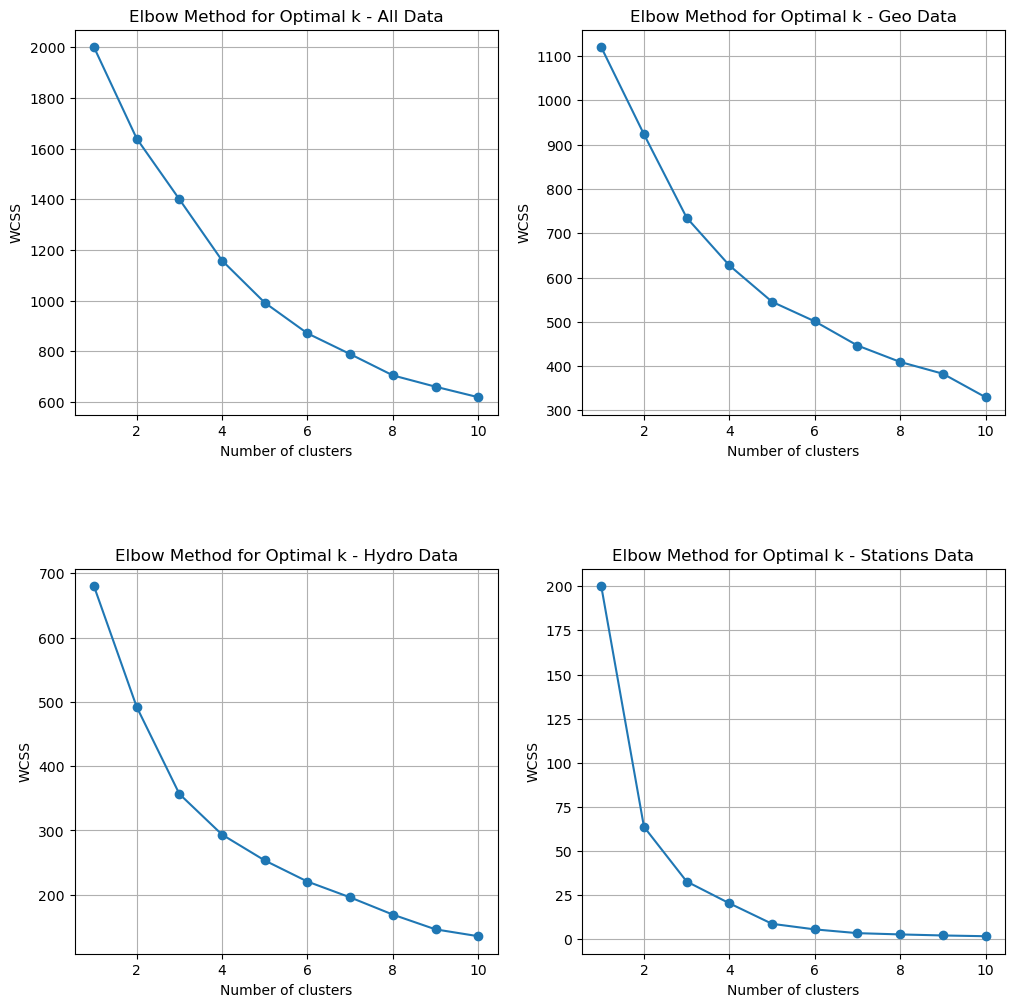

In [82]:
# WCSS stands for 'Within-Cluster-Sum-of-Squares' To find the optimal number of clusters

import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

# Create a 2x2 grid of subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
fig.subplots_adjust(hspace=0.4)  # Adjust vertical spacing between subplots

# Define data_scaled arrays and corresponding titles
data_scaled_list = [data_scaled_All, data_scaled_Geo, data_scaled_Hydro, data_scaled_Stations]
titles = ["All Data", "Geo Data", "Hydro Data", "Stations Data"]

# Loop through data_scaled arrays and titles to create subplots
for i, (data_scaled, title) in enumerate(zip(data_scaled_list, titles)):
    # WCSS stands for 'Within-Cluster-Sum-of-Squares' to find the optimal number of clusters
    wcss = []
    
    # Try different values of k (number of clusters) and calculate WCSS
    for j in range(1, 11):
        kmeans = KMeans(n_clusters=j, init='k-means++', max_iter=300, n_init=10, random_state=0)
        kmeans.fit(data_scaled)
        wcss.append(kmeans.inertia_)
    
    # Determine the row and column for the current subplot
    row = i // 2
    col = i % 2
    
    # Create the subplot
    ax = axes[row, col]
    
    # Plot the Elbow method graph
    ax.plot(range(1, 11), wcss, marker='o', linestyle='-')
    ax.set_title(f'Elbow Method for Optimal k - {title}')
    ax.set_xlabel('Number of clusters')
    ax.set_ylabel('WCSS')
    
    # Turn on grid for this subplot
    ax.grid(True)

# Save the hourly plot
output_folder = r'D:\Experiments\URA_attributes_v1.0\Plots'
plt.savefig(
    os.path.join(output_folder, 'Elbow_Method4CatchmentAttributesClustering.png'),
    dpi=300,  # Set the dpi value for high quality
    bbox_inches='tight'  # To ensure that the entire plot is saved
)

# Show the subplots
plt.show()


In [87]:
## This code clusterize catchments based on the elbow method

import warnings
from sklearn.cluster import KMeans

# Suppress warnings
warnings.filterwarnings("ignore")

def perform_clustering(data_scaled, attributes_df, output_file_path, k=4):
    """
    Perform k-means clustering on the given data_scaled and add cluster labels to attributes_df.
    
    Args:
        data_scaled (array-like): Scaled data for clustering.
        attributes_df (DataFrame): Original DataFrame with attributes.
        output_file_path (str): Path to save the clustered attributes DataFrame.
        k (int): Number of clusters for k-means clustering (default: 4).
    """
    # Perform k-means clustering
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    clusters = kmeans.fit_predict(data_scaled)

    # Add cluster labels to the original DataFrame
    attributes_df['Cluster'] = clusters

    # Save the results to a CSV file
    attributes_df.to_csv(output_file_path, index=False)

# Cluster all attributes
perform_clustering(data_scaled_All, attributes_df_All, r'D:\Experiments\URA_attributes_v1.0\Clusters\AllClustered_attributes.csv')

# Cluster Geo attributes
perform_clustering(data_scaled_Geo, attributes_df_Geo, r'D:\Experiments\URA_attributes_v1.0\Clusters\GeoClustered_attributes.csv', k=3)

# Cluster Hydro attributes
perform_clustering(data_scaled_Hydro, attributes_df_Hydro, r'D:\Experiments\URA_attributes_v1.0\Clusters\HydroClustered_attributes.csv', k=3)

# Cluster Stations attributes
perform_clustering(data_scaled_Stations, attributes_df_Stations, r'D:\Experiments\URA_attributes_v1.0\Clusters\StationsClustered.csv', k=2)


In [126]:
"""
Correlations catchments attributes and test metrics for the fully trained/tested models on both local and regional scale
"""

# Define the parent directory that contains the folders with config files
parent_dir = Path(r'D:\Experiments\Final80TrainedModels\ModelEvaluations')

# Set the directory for the results
results_dir = Path(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\figs')

# Load the data into a pandas DataFrame with column names
column_names = ['basin', 'freq', 'HPs_Set',
                'SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE',
                'SFmean_MSE', 'WLmean_MSE', 'SFinst_MSE', 'WLinst_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 'SFinst_RMSE', 'WLinst_RMSE',
                'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE', 'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFmean_Beta-NSE', 'WLmean_Beta-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFinst_Pearson-r', 'WLinst_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE', 'SFinst_Beta-KGE', 'WLinst_Beta-KGE',
                'SFmean_FHV', 'WLmean_FHV', 'SFinst_FHV', 'WLinst_FHV', 'SFmean_FMS', 'WLmean_FMS', 'SFinst_FMS', 'WLinst_FMS',
                'SFmean_FLV', 'WLmean_FLV', 'SFinst_FLV', 'WLinst_FLV', 'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 'SFinst_Peak-Timing', 'WLinst_Peak-Timing',
                'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE', 'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFmean_Missed-Peaks', 'WLmean_Missed-Peaks', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks',
                'AreaKm2', 'CONF_DEN', 'Mean_GRADIENT', 'Mean_GRAD', 'MIN_Slope', 'MAX_Slope', 'Mean_Slope',
                'Mean_elevM', 'MIN_Hight', 'MAX_Hight', 'Mean_Hight', '%UHD', '%AGR', '%PAS', '%BLF', '%CNF', '%PLT', '%SSH', '%WAE', '%DEN', '%CALC', '%CONG', '%SDIM', '%VLC', '%WATR', 'Rock_Conductivity', 'Permeability', 'Rock_Hardness',
                'Mean_anual_PREC', 'Mean_anual_TEMP', 'Possible_Snow', 'Days_Temp_Negative',
                'RCinst', 'RCmean', 'Aridity_Index', 'Mean_Lumped_Prec_URA', 'Mean_Lumped_FlowInst', 'Mean_Lumped_FlowMean', 'Mean_Lumped_Temp', 'Min_Lumped_Temp', 'Max_Lumped_Temp',
                'CV_Prec', 'CV_FlowInst', 'CV_FlowMean', 'Mean_PET', 'Prec_stations_No.', 'Temp_stations_No.', 'nanprec', 'nantemp', 'temp_stations_2',
                'All_attributes_cluster', 'Geo_attributes_cluster', 'Hydro_attributes_cluster', 'Stations_cluster', 'Mean_Prec_modified']

df_Basins = pd.read_csv(parent_dir / 'merged_results_values_set_withAttributes.csv', skiprows=[0], names=column_names).fillna(0)
df_Overal = pd.read_csv(parent_dir / 'merged_results_values_set_basins_withAttributes.csv', skiprows=[0], names=column_names).fillna(0)
df_Basins_drop = pd.read_csv(parent_dir / 'merged_results_values_set_withAttributes.csv', skiprows=[0], names=column_names).dropna()
df_Overal_drop = pd.read_csv(parent_dir / 'merged_results_values_set_basins_withAttributes.csv', skiprows=[0], names=column_names).dropna()

cols1 = ['AreaKm2','CONF_DEN']
cols2 = ['Mean_GRADIENT', 'Mean_GRAD','MIN_Slope','MAX_Slope','Mean_Slope']
cols3 = ['Mean_elevM','MIN_Hight','MAX_Hight','Mean_Hight']
cols4 = ['%UHD', '%AGR', '%PAS', '%BLF', '%CNF', '%PLT', '%SSH', '%WAE', '%DEN']
cols5 = ['%CALC', '%CONG', '%SDIM', '%VLC', '%WATR']
cols6 = ['Rock_Conductivity', 'Permeability', 'Rock_Hardness']
cols7 = ['Prec_stations_No.', 'Temp_stations_No.', 'nanprec', 'nantemp', 'temp_stations_2']
cols8 = ['Mean_anual_PREC', 'Mean_Lumped_Prec_URA', 'Mean_anual_TEMP', 'Possible_Snow', 'Days_Temp_Negative', 'Mean_Lumped_Temp', 'Min_Lumped_Temp', 'Max_Lumped_Temp']
cols8_1 = ['Mean_Prec_modified', 'Mean_anual_TEMP', 'Possible_Snow', 'Days_Temp_Negative', 'Mean_Lumped_Temp', 'Min_Lumped_Temp', 'Max_Lumped_Temp']
cols9 = ['RCinst',	'RCmean',	'Aridity_Index',	'Mean_Lumped_FlowInst', 'Mean_Lumped_FlowMean']
cols10 = ['CV_Prec',	'CV_FlowInst',	'CV_FlowMean',	'Mean_PET']
cols11 = ['All_attributes_cluster', 'Geo_attributes_cluster', 'Hydro_attributes_cluster', 'Stations_cluster']
cols12 = ['freq', 'HPs_Set']

col_obj_mean_1 = ['SFmean_NSE', 'WLmean_NSE', 'SFmean_KGE', 'WLmean_KGE', 
                'SFmean_MSE', 'WLmean_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 
                'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE', 'SFmean_Beta-NSE', 'WLmean_Beta-NSE', 
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE']

col_obj_mean_2 = ['SFmean_FHV', 'WLmean_FHV', 'SFmean_FMS', 'WLmean_FMS', 
                'SFmean_FLV', 'WLmean_FLV', 'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 
                'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE', 'SFmean_Missed-Peaks', 'WLmean_Missed-Peaks']

col_obj_inst_1 = ['SFinst_NSE', 'WLinst_NSE', 'SFinst_KGE', 'WLinst_KGE',
                'SFinst_MSE', 'WLinst_MSE', 'SFinst_RMSE', 'WLinst_RMSE',
                'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFinst_Pearson-r', 'WLinst_Pearson-r', 'SFinst_Beta-KGE', 'WLinst_Beta-KGE']

col_obj_inst_2 = ['SFinst_FHV', 'WLinst_FHV', 'SFinst_FMS', 'WLinst_FMS',
                'SFinst_FLV', 'WLinst_FLV', 'SFinst_Peak-Timing', 'WLinst_Peak-Timing',
                'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks']

col_obj_mean_drop = ['WLmean_NSE', 'WLmean_KGE', 
                'WLmean_MSE', 'WLmean_RMSE', 
                'WLmean_Alpha-NSE', 'WLmean_Beta-NSE', 
                'WLmean_Pearson-r', 'WLmean_Beta-KGE',
                'WLmean_FHV', 'WLmean_FMS', 
                'WLmean_FLV', 'WLmean_Peak-Timing', 
                'WLmean_Peak-MAPE', 'WLmean_Missed-Peaks']

dfs = [df_Basins, df_Basins_drop, df_Overal, df_Overal_drop]
col_objs = [col_obj_mean_1, col_obj_mean_2, col_obj_inst_1, col_obj_inst_2, col_obj_mean_drop]
col_nums = [cols1, cols2, cols3, cols4, cols5, cols6, cols7, cols8, cols8_1, cols9, cols10, cols11, cols12]

dfs_names = ['df_Basins', 'df_Basins_drop', 'df_Overal', 'df_Overal_drop']
col_objs_names = ['col_obj_mean_1', 'col_obj_mean_2', 'col_obj_inst_1', 'col_obj_inst_2', 'col_obj_mean_drop']
col_nums_names = ['cols1', 'cols2', 'cols3', 'cols4', 'cols5', 'cols6', 'cols7', 'cols8', 'cols8_1', 'cols9', 'cols10', 'cols11', 'cols12']

for i, df in enumerate(dfs):
    df_name = dfs_names[i]
    for j, col_obj in enumerate(col_objs):
        col_obj_name = col_objs_names[j]
        for k, col_num in enumerate(col_nums):
            col_num_name = col_nums_names[k]
            
            # Construct a meaningful filename
            filename = f'{df_name}_{col_obj_name}_{col_num_name}.tiff'

            # Concatenate DataFrames to combine the columns of interest
            obj_df = pd.concat([df[col_obj], df[col_num]], axis=1)

            # Calculate the correlation matrix
            correlation_matrix = obj_df.corr()

            # Create a larger figure
            plt.figure(figsize=(16, 8))  # Decreased the height of the figure

            # Create a heatmap with rotated Y-axis labels
            ax = sns.heatmap(correlation_matrix.loc[col_obj, col_num], annot=True, cmap='coolwarm', fmt=".2f")
            plt.title("Correlation Heatmap; LSTMs' SF/WL prediction metrics vs. catchment attributes on the test set")

            # Rotate Y-axis labels vertically
            plt.yticks(rotation=0)  # Change 0 to 90 if you want them fully vertical

            # Automatically adjust subplot parameters for a better fit
            plt.tight_layout()

            # Save the plot to the specified directory in TIFF format with increased DPI
            plt.savefig(results_dir / filename, dpi=300, format='tiff')
            plt.close()


In [185]:
"""
Correlations catchments attributes and test metrics for the fully trained/tested models on both local and regional scale (For Corrs > 0.3)
"""

# Define the parent directory that contains the folders with config files
parent_dir = Path(r'D:\Experiments\Final80TrainedModels\ModelEvaluations')

# Set the directory for the results
results_dir = Path(r'D:\Experiments\Final80TrainedModels\ModelEvaluations\figs')

# Load the data into a pandas DataFrame with column names
column_names = ['basin', 'freq', 'HPs_Set',
                'SFmean_NSE', 'WLmean_NSE', 'SFinst_NSE', 'WLinst_NSE', 'SFmean_KGE', 'WLmean_KGE', 'SFinst_KGE', 'WLinst_KGE',
                'SFmean_MSE', 'WLmean_MSE', 'SFinst_MSE', 'WLinst_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 'SFinst_RMSE', 'WLinst_RMSE',
                'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE', 'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFmean_Beta-NSE', 'WLmean_Beta-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFinst_Pearson-r', 'WLinst_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE', 'SFinst_Beta-KGE', 'WLinst_Beta-KGE',
                'SFmean_FHV', 'WLmean_FHV', 'SFinst_FHV', 'WLinst_FHV', 'SFmean_FMS', 'WLmean_FMS', 'SFinst_FMS', 'WLinst_FMS',
                'SFmean_FLV', 'WLmean_FLV', 'SFinst_FLV', 'WLinst_FLV', 'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 'SFinst_Peak-Timing', 'WLinst_Peak-Timing',
                'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE', 'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFmean_Missed-Peaks', 'WLmean_Missed-Peaks', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks',
                'AreaKm2', 'CONF_DEN', 'Mean_GRADIENT', 'Mean_GRAD', 'MIN_Slope', 'MAX_Slope', 'Mean_Slope',
                'Mean_elevM', 'MIN_Hight', 'MAX_Hight', 'Mean_Hight', '%UHD', '%AGR', '%PAS', '%BLF', '%CNF', '%PLT', '%SSH', '%WAE', '%DEN', '%CALC', '%CONG', '%SDIM', '%VLC', '%WATR', 'Rock_Conductivity', 'Permeability', 'Rock_Hardness',
                'Mean_anual_PREC', 'Mean_anual_TEMP', 'Possible_Snow', 'Days_Temp_Negative',
                'RCinst', 'RCmean', 'Aridity_Index', 'Mean_Lumped_Prec_URA', 'Mean_Lumped_FlowInst', 'Mean_Lumped_FlowMean', 'Mean_Lumped_Temp', 'Min_Lumped_Temp', 'Max_Lumped_Temp',
                'CV_Prec', 'CV_FlowInst', 'CV_FlowMean', 'Mean_PET', 'Prec_stations_No.', 'Temp_stations_No.', 'nanprec', 'nantemp', 'temp_stations_2',
                'All_attributes_cluster', 'Geo_attributes_cluster', 'Hydro_attributes_cluster', 'Stations_cluster', 'Mean_Prec_modified']

cols1 = ['AreaKm2','CONF_DEN']
cols2 = ['Mean_GRADIENT', 'Mean_GRAD','MIN_Slope','MAX_Slope','Mean_Slope']
cols3 = ['Mean_elevM','MIN_Hight','MAX_Hight','Mean_Hight']
cols4 = ['%UHD', '%AGR', '%PAS', '%BLF', '%CNF', '%PLT', '%SSH', '%WAE', '%DEN']
cols5 = ['%CALC', '%CONG', '%SDIM', '%VLC', '%WATR']
cols6 = ['Rock_Conductivity', 'Permeability', 'Rock_Hardness']
cols7 = ['Prec_stations_No.', 'Temp_stations_No.', 'nanprec', 'nantemp', 'temp_stations_2']
cols8 = ['Mean_anual_PREC', 'Mean_Lumped_Prec_URA', 'Mean_Prec_modified', 'Mean_anual_TEMP', 'Possible_Snow', 'Days_Temp_Negative', 'Mean_Lumped_Temp', 'Min_Lumped_Temp', 'Max_Lumped_Temp']
cols9 = ['RCinst',	'RCmean',	'Aridity_Index',	'Mean_Lumped_FlowInst', 'Mean_Lumped_FlowMean']
cols10 = ['CV_Prec',	'CV_FlowInst',	'CV_FlowMean',	'Mean_PET']
cols11 = ['All_attributes_cluster', 'Geo_attributes_cluster', 'Hydro_attributes_cluster', 'Stations_cluster']
cols12 = ['freq', 'HPs_Set']

col_obj_mean_1 = ['SFmean_NSE', 'WLmean_NSE', 'SFmean_KGE', 'WLmean_KGE', 
                'SFmean_MSE', 'WLmean_MSE', 'SFmean_RMSE', 'WLmean_RMSE', 
                'SFmean_Alpha-NSE', 'WLmean_Alpha-NSE', 'SFmean_Beta-NSE', 'WLmean_Beta-NSE', 
                'SFmean_Pearson-r', 'WLmean_Pearson-r', 'SFmean_Beta-KGE', 'WLmean_Beta-KGE']

col_obj_mean_2 = ['SFmean_FHV', 'WLmean_FHV', 'SFmean_FMS', 'WLmean_FMS', 
                'SFmean_FLV', 'WLmean_FLV', 'SFmean_Peak-Timing', 'WLmean_Peak-Timing', 
                'SFmean_Peak-MAPE', 'WLmean_Peak-MAPE', 'SFmean_Missed-Peaks', 'WLmean_Missed-Peaks']

col_obj_inst_1 = ['SFinst_NSE', 'WLinst_NSE', 'SFinst_KGE', 'WLinst_KGE',
                'SFinst_MSE', 'WLinst_MSE', 'SFinst_RMSE', 'WLinst_RMSE',
                'SFinst_Alpha-NSE', 'WLinst_Alpha-NSE', 'SFinst_Beta-NSE', 'WLinst_Beta-NSE',
                'SFinst_Pearson-r', 'WLinst_Pearson-r', 'SFinst_Beta-KGE', 'WLinst_Beta-KGE']

col_obj_inst_2 = ['SFinst_FHV', 'WLinst_FHV', 'SFinst_FMS', 'WLinst_FMS',
                'SFinst_FLV', 'WLinst_FLV', 'SFinst_Peak-Timing', 'WLinst_Peak-Timing',
                'SFinst_Peak-MAPE', 'WLinst_Peak-MAPE', 'SFinst_Missed-Peaks', 'WLinst_Missed-Peaks']

col_obj_mean_drop = ['WLmean_NSE', 'WLmean_KGE', 
                'WLmean_MSE', 'WLmean_RMSE', 
                'WLmean_Alpha-NSE', 'WLmean_Beta-NSE', 
                'WLmean_Pearson-r', 'WLmean_Beta-KGE',
                'WLmean_FHV', 'WLmean_FMS', 
                'WLmean_FLV', 'WLmean_Peak-Timing', 
                'WLmean_Peak-MAPE', 'WLmean_Missed-Peaks']

df_Basins = pd.read_csv(parent_dir / 'merged_results_values_set_withAttributes.csv', skiprows=[0], names=column_names).fillna(0)
df_Overal = pd.read_csv(parent_dir / 'merged_results_values_set_basins_withAttributes.csv', skiprows=[0], names=column_names).fillna(0)
df_Basins_drop = pd.read_csv(parent_dir / 'merged_results_values_set_withAttributes.csv', skiprows=[0], names=column_names).dropna()
df_Overal_drop = pd.read_csv(parent_dir / 'merged_results_values_set_basins_withAttributes.csv', skiprows=[0], names=column_names).dropna()

df_Basins_hr = df_Basins[df_Basins['freq'] != 2]
df_Overal_hr = df_Overal[df_Overal['freq'] != 2]
df_Basins_day = df_Basins[df_Basins['freq'] != 1]
df_Overal_day = df_Overal[df_Overal['freq'] != 1]
df_Basins_drop_hr = df_Basins_drop[df_Basins_drop['freq'] != 2]
df_Overal_drop_hr = df_Overal_drop[df_Overal_drop['freq'] != 2]
df_Basins_drop_day = df_Basins_drop[df_Basins_drop['freq'] != 1]
df_Overal_drop_day = df_Overal_drop[df_Overal_drop['freq'] != 1]

selected_attributes = cols1 + cols2 + cols3 + cols4 + cols5 + cols6 + cols7 + cols8 + cols8_1 + cols9 + cols10 + cols11 + cols12 

# Define the custom colormap
colors = [(0.0, 'red'), (0.4, 'white'), (0.6, 'white'), (1.0, 'blue')]
cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors)

def generate_correlation_heatmap(dfs, dfs_names, selected_metrics, selected_metrics_names, selected_attributes, results_dir):
    for i, df in enumerate(dfs):
        df_name = dfs_names[i]
        for j, selected_metric in enumerate(selected_metrics):
            selected_metric_name = selected_metrics_names[j]

            # Construct a meaningful filename
            filename = f'{df_name}_{selected_metric_name}.tiff'

            # Concatenate DataFrames to combine the columns of interest
            correlation_data = pd.concat([df[selected_metric], df[selected_attributes]], axis=1)

            # Calculate the correlation matrix
            correlation_matrix = correlation_data.corr()

            # Filter out numbers less than 0.2 from the correlation_matrix
            correlation_matrix_filtered = correlation_matrix.loc[selected_metric, selected_attributes].applymap(lambda x: x if abs(x) >= 0.25 else np.nan)

            # Create a larger figure
            plt.figure(figsize=(16, 8))

            # Add light gray grids behind the plot
            plt.grid(visible=True, linestyle='--', alpha=0.7, color='gainsboro', linewidth=0.5) # 'whitesmoke', 'gainsboro', or 'lightgrey'

            # Create a heatmap with rotated Y-axis labels using the custom colormap
            heatmap = sns.heatmap(correlation_matrix_filtered, annot=True, cmap=cmap, fmt=".1f", annot_kws={"size": 5}, cbar=True)

            plt.title("Correlation Heatmap: LSTM SF/WL Prediction Metrics vs. Catchment Attributes (Test Set)")

            # Decrease font size
            plt.xticks(fontsize=10)
            plt.yticks(fontsize=10)

            # Add a frame around the plot area
            ax = plt.gca()
            rect = plt.Rectangle((0, 0), 1, 1, linewidth=1, edgecolor='black', facecolor='none', transform=ax.transAxes)
            ax.add_patch(rect)

            # Automatically adjust subplot parameters for a better fit
            plt.tight_layout()

            # Save the plot to the specified directory in TIFF format with increased DPI
            plt.savefig(results_dir / filename, dpi=300, format='tiff', bbox_inches='tight')
            plt.close()
            
# Part 01
dfs = [df_Basins, df_Overal, df_Basins_hr, df_Overal_hr, df_Basins_day, df_Overal_day]
dfs_names = ['df_Basins', 'df_Overal', 'df_Basins_hr', 'df_Overal_hr', 'df_Basins_day', 'df_Overal_day']

selected_metrics_mean = col_obj_mean_1 + col_obj_mean_2
selected_metrics_inst = col_obj_inst_1 + col_obj_inst_2

generate_correlation_heatmap(dfs, dfs_names, [selected_metrics_mean, selected_metrics_inst], ['selected_metrics_mean', 'selected_metrics_inst'], selected_attributes, results_dir)

# Part 02
dfs = [df_Basins_drop, df_Overal_drop, df_Basins_drop_hr, df_Overal_drop_hr, df_Basins_drop_day, df_Overal_drop_day]
dfs_names = ['df_Basins_drop', 'df_Overal_drop', 'df_Basins_drop_hr', 'df_Overal_drop_hr', 'df_Basins_drop_day', 'df_Overal_drop_day']

selected_metrics_drop = col_obj_mean_drop

generate_correlation_heatmap(dfs, dfs_names, [selected_metrics_drop], ['selected_metrics_drop'], selected_attributes, results_dir)


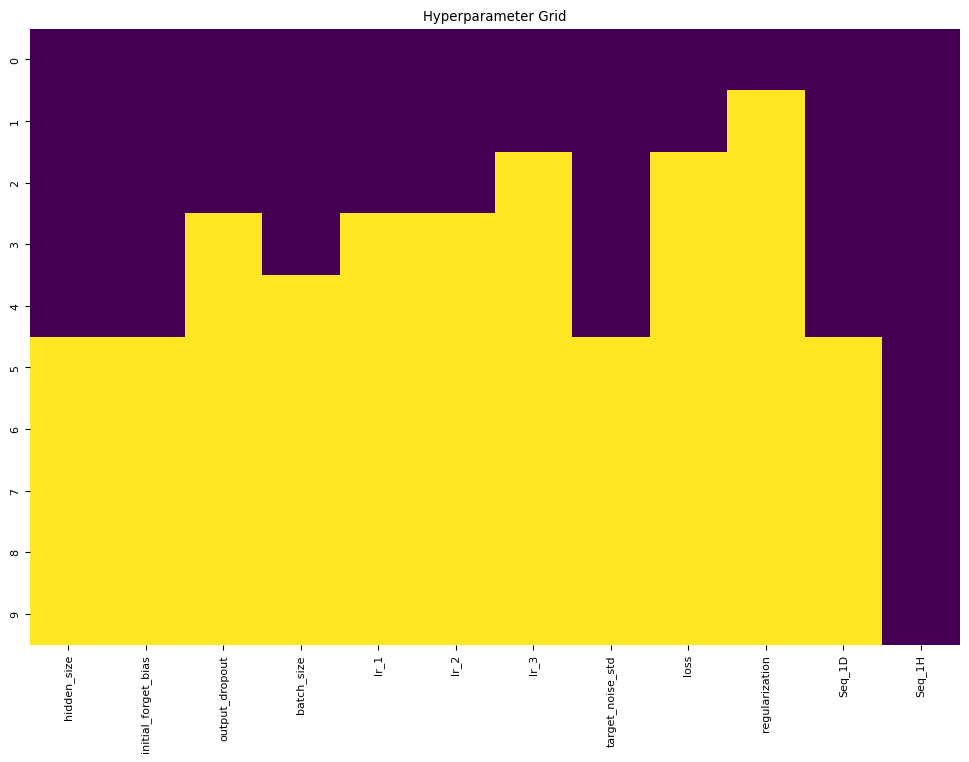

In [208]:
## Plot the HPs space
# Define your hyperparameter grid
param_grid = {
    'hidden_size': [16, 32, 64, 128, 256],
    'initial_forget_bias': [-3, -1, 0, 1, 3],
    'output_dropout': [0, 0.2, 0.4],
    'batch_size': [32, 64, 128, 256],
    'lr_1': [1e-3, 1e-2, 5e-2, None, None],
    'lr_2': [5e-4, 1e-3, 5e-3, None, None],
    'lr_3': [1e-4, 1e-3, None, None, None],
    'target_noise_std': [0, 0.01, 0.02, 0.05, 0.1],
    'loss': ['NSE', 'RMSE', None, None, None],
    'regularization': ['tie_frequencies', None, None, None, None],
    'Seq_1D': [146, 182, 365, 730, 1095],
    'Seq_1H': [168, 336, 504, 672, 1344, 2016, 4032, 6720, 8064, 8760]
}

# Normalize the hyperparameter lists to have the same length
max_length = max(len(values) for values in param_grid.values())
for key, values in param_grid.items():
    if len(values) < max_length:
        param_grid[key] = values + [None] * (max_length - len(values))

# Create a DataFrame from the hyperparameter grid
df = pd.DataFrame(param_grid)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Hyperparameter Grid')
plt.show()


In [ ]:
"""
Analysis of Model Performance metrics_of_interest
Box Plots of metrics for Hourly and Daily Frequency Models
"""

# Subset the DataFrame to only include the 'levelinst_NSE' metric
metrics_of_interest = df_cluster['metrics_of_interest']

# Split the results based on frequency (1H or 1D)
hourly_results  = metrics_of_interest[df_cluster['freq'] == '1H']
daily_results   = metrics_of_interest[df_cluster['freq'] == '1D']

# Compute summary statistics for hourly results
hourly_mean     = hourly_results.mean()
hourly_std_dev  = hourly_results.std()
hourly_variance = hourly_results.var()

# Compute summary statistics for daily results
daily_mean      = daily_results.mean()
daily_std_dev   = daily_results.std()
daily_variance  = daily_results.var()

# Format summary statistics to display 2 decimal places
hourly_mean_str     = f'{hourly_mean:.2f}'
hourly_std_dev_str  = f'{hourly_std_dev:.2f}'
hourly_variance_str = f'{hourly_variance:.2f}'
daily_mean_str      = f'{daily_mean:.2f}'
daily_std_dev_str   = f'{daily_std_dev:.2f}'
daily_variance_str  = f'{daily_variance:.2f}'

# Create box plots for hourly and daily results
fig, ax = plt.subplots(figsize=(8, 6))

# Plot box plot of daily results
ax.boxplot(daily_results, whis=0.5, positions=[1])
ax.set_ylim([daily_results.min() - 0.05, daily_results.max() + 0.05]) # set y-axis limits

# Plot box plot of hourly results
ax.boxplot(hourly_results, whis=1.5, positions=[0], boxprops={'color': 'red'})
ax.set_xticks([0, 1])
ax.set_xticklabels(['hourly', 'daily'])
ax.set_ylabel('NSE')
ax.set_ylim([hourly_results.min() - 0.05, hourly_results.max() + 0.05]) # set y-axis limits

# Add summary statistics to the plot
ax.text(-0.4, hourly_results.max() - 0.07, 'Hourly:\n...........\n' + f'Mean: {hourly_mean_str}\nSD: {hourly_std_dev_str}\nVar: {hourly_variance_str}', ha='left', va='center')
ax.text(0.6, daily_results.max() - 0.05, 'Daily:\n.........\n' + f'Mean: {daily_mean_str}\nSD: {daily_std_dev_str}\nVar: {daily_variance_str}', ha='left', va='center')

# Add legend
red_patch = plt.plot([], [], 's', mec='k', mew=1, ms=10, c='r', label='Hourly')
black_patch = plt.plot([], [], 's', mec='k', mew=1, ms=10, c='k', label='Daily')
plt.legend(handles=[red_patch[0], black_patch[0]], loc='upper right')

# Remove tick labels on x-axis
ax.set_xticks([0, 1])
ax.set_xticklabels(['', ''])

# Adjust the figure layout
fig.subplots_adjust(wspace=0.3) # make y-axes same size
fig.suptitle('Overall of NSE and KGE metrics')

plt.show()

# Save the figure as a high-quality TIFF file
fig.savefig(results_dir_cluster / 'metrics_of_interest.tiff', dpi=300, format='tiff')


In [ ]:
"""
Pairwise Scatterplots to Visualize Relationships between Hydrological Model Variables

Figure Title: "Pairwise Scatterplots of Hydrological Model Variables"
"""

# Create pairwise scatterplots using Seaborn
# 'pairplot' creates a matrix of scatterplots showing the relationships between pairs of variables
# 'diag_kind' specifies that the diagonal plots should be histograms rather than density estimates
# 'corner' specifies that the upper triangle of the plot matrix should be blank
sns.pairplot(df_cluster.drop(columns=['Seq_1D','Seq_1H','batch_size','target_noise_std','Lr0','Lr10','Lr25',
                        'loss','hidden_size','output_dropout','initial_forget_bias','Folder',
                        'basin','freq']), diag_kind='hist', corner=True)

# Display the plot
# This will open a new window with the plot if you're running the code in a Jupyter Notebook
# If you're running the code in a standalone script, you'll need to save the plot to a file or display it using a different method

# Get the current figure object
fig = plt.gcf()

# Save the figure as a high-quality TIFF file
fig.savefig(results_dir_cluster / 'Pairwise_Metrics.tiff', dpi=300, format='tiff')


In [ ]:
"""
Correlation Heatmap of Hyperparameters vs. Metrics in NeuralHydrology mtsLSTM Runs
"""

# Select the columns of interest
columns_of_interest = ['Seq_1D', 'Seq_1H', 'batch_size', 'target_noise_std', 'Lr0', 'Lr10', 'Lr25',
                        'hidden_size', 'output_dropout', 'initial_forget_bias', 'streamflowmean_NSE', 'levelmean_NSE', 'streamflowinst_NSE', 'levelinst_NSE', 
                        'streamflowmean_KGE', 'levelmean_KGE', 'streamflowinst_KGE', 'levelinst_KGE',
                        'metrics_of_interest', 'NSEmetrics_of_interest', 'KGEmetrics_of_interest']

# Select columns for x and y axes
x_cols = ['streamflowmean_NSE', 'levelmean_NSE', 'streamflowinst_NSE', 'levelinst_NSE', 
          'streamflowmean_KGE', 'levelmean_KGE', 'streamflowinst_KGE', 'levelinst_KGE',
          'metrics_of_interest', 'NSEmetrics_of_interest', 'KGEmetrics_of_interest']
y_cols = ['Seq_1D', 'Seq_1H', 'batch_size', 'output_dropout', 'target_noise_std', 'hidden_size', 
          'Lr25','Lr10','Lr0', 'initial_forget_bias']

# Subset the dataframe with the columns of interest
df_corr = df_cluster[columns_of_interest]

# Compute correlation matrix
corr_matrix = df_corr.corr()

# Create heatmap of the correlation matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix.loc[y_cols, x_cols], cmap="YlGnBu", annot=True, annot_kws={"size": 12})
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

# Add title and show plot
plt.title('Correlation Heatmap of Hyperparameters and Performance Metrics', fontsize=16, fontweight='bold')

# Save figure
plt.savefig(results_dir_cluster / 'Heatmap of Params_vs_Metrics.tiff', dpi=300)

plt.show()


In [ ]:
"""
This script performs hyperparameter clustering and statistical analysis
        using KMeans, Seaborn Box Plot, and Pandas GroupBy.
"""

# Specify the number of clusters
N_CLUSTERS = 10

# Instantiate KMeans object and fit to data
kmeans = KMeans(n_clusters=N_CLUSTERS)
kmeans.fit(df_cluster.drop(columns=['Folder', 'basin', 'freq','loss']).astype(float))

# Assign cluster labels to each data point
df_cluster['Cluster'] = kmeans.labels_

# Group the data by cluster and calculate the mean KGE and NSE for each cluster
cluster_stats = df_cluster.groupby('Cluster')[['streamflowmean_NSE', 'levelmean_NSE', 
                                               'streamflowinst_NSE', 'levelinst_NSE', 
                                               'streamflowmean_KGE', 'levelmean_KGE', 
                                               'streamflowinst_KGE', 'levelinst_KGE',
                                               'metrics_of_interest', 'NSEmetrics_of_interest', 
                                               'KGEmetrics_of_interest']].mean()

# Print the cluster statistics
print("Cluster Statistics:\n", cluster_stats)

# Create a boxplot of the KGE values for each cluster
sns.boxplot(x='Cluster', y='metrics_of_interest', data=df)

# Find the label of the cluster with the highest metrics
best_cluster_label = cluster_stats['metrics_of_interest'].idxmax()

# Select the rows corresponding to the best cluster
best_cluster_df = df_cluster[df_cluster['Cluster'] == best_cluster_label]

# Print the DataFrame containing the best cluster
print("Best Cluster:\n", best_cluster_df)

# Get the current figure object
fig = plt.gcf()

# Save the figure as a high-quality TIFF file
fig.savefig(results_dir_cluster / 'Cluster_10n.tiff', dpi=300, format='tiff')


In [ ]:
"""
Random Forest Regression for predictive modeling:
"""

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop(columns=['Folder', 
                                                    'basin', 'freq','loss',
                                                    'streamflowmean_NSE', 'levelmean_NSE', 
                                                    'streamflowinst_NSE', 'levelinst_NSE', 
                                                    'streamflowmean_KGE', 'levelmean_KGE', 
                                                    'streamflowinst_KGE', 'levelinst_KGE',
                                                    'metrics_of_interest', 'NSEmetrics_of_interest', 
                                                    'KGEmetrics_of_interest']).astype(float), 
                                                    df_cluster['metrics_of_interest'], test_size=0.2, random_state=42)

# Instantiate Random Forest Regression object and fit to training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on test data
y_pred = rf.predict(X_test)

# Create scatter plot of predicted versus actual values
plt.figure(figsize=(6,6)) # Set the size of the plot to be 6x6 inches
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression Model on metrics of interest (NSE & KGE)')
plt.grid(alpha=0.2) # Add a light grid with alpha of 0.2 for transparency

# Save the figure as a high-quality TIFF file
plt.savefig(results_dir_cluster/'Random_forest_overall_NSEKGE.tiff', dpi=300, format='tiff')

plt.show()

## Model evaluation:

# The performance of the model can be interpreted using various metrics 
# such as mean squared error, R-squared, and root mean squared error. 
# These metrics will give an idea of how well the model is performing 
# in terms of predicting the target variable (levelinst_NSE). 
# The closer the metrics are to 1, the better the model is performing. 
# Additionally, the model can be evaluated by visually comparing the predicted values
# with the actual values using plots or other visualization techniques.

## In the context of this code, "Actual" refers to the actual observed values
# of the target variable (metrics of interest) in the test dataset, while "Predicted" 
# refers to the values predicted by the Random Forest Regression model for the same test dataset. 
# The scatter plot created by the code shows the relationship between the actual 
# and predicted values, where each point represents a pair of actual and predicted values
# for a single data point in the test dataset. The closer the points are to the diagonal line (y=x),
# the better the model is at predicting the target variable.


In [ ]:
"""
Random Forest Regression for predictive modeling:
"""

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop(columns=['Folder', 
                                                    'basin', 'freq','loss',
                                                    'streamflowmean_NSE', 'levelmean_NSE', 
                                                    'streamflowinst_NSE', 'levelinst_NSE', 
                                                    'streamflowmean_KGE', 'levelmean_KGE', 
                                                    'streamflowinst_KGE', 'levelinst_KGE',
                                                    'metrics_of_interest', 'NSEmetrics_of_interest', 
                                                    'KGEmetrics_of_interest']).astype(float), 
                                                    df_cluster['NSEmetrics_of_interest'], test_size=0.2, random_state=42)

# Instantiate Random Forest Regression object and fit to training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on test data
y_pred = rf.predict(X_test)

# Create scatter plot of predicted versus actual values
plt.figure(figsize=(6,6)) # Set the size of the plot to be 6x6 inches

# Set the limits of the plot to be the same on both axes
xlim = (min(y_test.min() - 0.002, y_pred.min() - 0.002), max(y_test.max() + 0.002, y_pred.max() + 0.002))
plt.xlim(xlim)
plt.ylim(xlim)

plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression Model on Overall NSE')
plt.grid(alpha=0.2) # Add a light grid with alpha of 0.2 for transparency

# Save the figure as a high-quality TIFF file
plt.savefig(results_dir_cluster/'Random_forest_overall_NSE.tiff', dpi=300, format='tiff')

plt.show()


In [ ]:
"""
Random Forest Regression for predictive modeling:
"""

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_cluster.drop(columns=['Folder', 
                                                    'basin', 'freq','loss',
                                                    'streamflowmean_NSE', 'levelmean_NSE', 
                                                    'streamflowinst_NSE', 'levelinst_NSE', 
                                                    'streamflowmean_KGE', 'levelmean_KGE', 
                                                    'streamflowinst_KGE', 'levelinst_KGE',
                                                    'metrics_of_interest', 'NSEmetrics_of_interest', 
                                                    'KGEmetrics_of_interest']).astype(float), 
                                                    df_cluster['KGEmetrics_of_interest'], test_size=0.2, random_state=42)

# Instantiate Random Forest Regression object and fit to training data
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions on test data
y_pred = rf.predict(X_test)

# Create scatter plot of predicted versus actual values
plt.figure(figsize=(6,6)) # Set the size of the plot to be 6x6 inches
plt.scatter(y_test, y_pred)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Random Forest Regression Model on Overall KGE')
plt.grid(alpha=0.2) # Add a light grid with alpha of 0.2 for transparency

# Save the figure as a high-quality TIFF file
plt.savefig(results_dir_cluster/'Random_forest_overall_KGE.tiff', dpi=300, format='tiff')

plt.show()


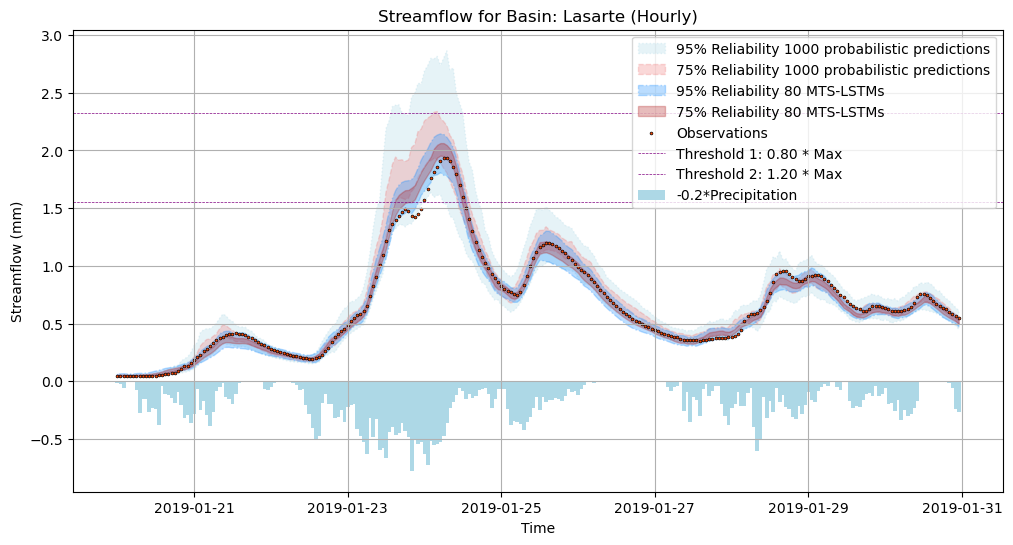

In [195]:
## To plot all final 80 models and CMAL samples 97% and 75% plots for hourly for Lasarte for a period

def plot_simulations(start_date_hr, end_date_hr, basin):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')

    # Load hourly observation data
    obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_hourly.csv'))

    # Load hourly precipitation data
    prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

    # Load percentiles data (hourly)
    hourly_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()
    CMAL_hourly_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
    CMAL_hourly_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
    CMAL_hourly_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
    CMAL_hourly_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()

    # Select a subset of the timestamp array within the specified date range
    mask = (obs_hourly_timestamp['timestamp'] >= start_date_hr) & (obs_hourly_timestamp['timestamp'] <= end_date_hr)
    timestamp_subset_hourly = obs_hourly_timestamp['timestamp'][mask].values

    # Define threshold values
    threshold_hr_1 = obs_hourly[mask].max(axis=0) * 0.80
    threshold_hr_2 = obs_hourly[mask].max(axis=0) * 1.20

    # Create hourly plot (95% and 75% percentiles)

    plt.figure(figsize=(12, 6))

    # Define line styles for the threshold lines
    threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}

    # Use different grayscale colors for the percentiles
#    plt.fill_between(timestamp_subset_hourly, CMAL_hourly_percentiles_5[mask], CMAL_hourly_percentiles_95[mask], color='lightgray', linestyle=':', alpha=0.3, label='95% Reliability CMAL')
#    plt.fill_between(timestamp_subset_hourly, CMAL_hourly_percentiles_25[mask], CMAL_hourly_percentiles_75[mask], color='gray', linestyle='--', alpha=0.3, label='75% Reliability CMAL')
    plt.fill_between(timestamp_subset_hourly, CMAL_hourly_percentiles_5[mask], CMAL_hourly_percentiles_95[mask], color='lightblue', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
    plt.fill_between(timestamp_subset_hourly, CMAL_hourly_percentiles_25[mask], CMAL_hourly_percentiles_75[mask], color='lightcoral', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

    # Use different grayscale colors for other lines
#    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_5[mask], hourly_percentiles_95[mask], color='darkgray', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
#    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_25[mask], hourly_percentiles_75[mask], color='dimgray', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_5[mask], hourly_percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_25[mask], hourly_percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')

    plt.scatter(timestamp_subset_hourly, obs_hourly[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
    plt.bar(timestamp_subset_hourly, -0.2 * prec_hourly[mask], color='lightblue', label='-0.2*Precipitation', width=0.05)
    plt.axhline(y=0.8 * np.max(obs_hourly[mask]), **threshold_style, label='Threshold 1: 0.80 * Max')
    plt.axhline(y=1.2 * np.max(obs_hourly[mask]), **threshold_style, label='Threshold 2: 1.20 * Max')

    plt.xlabel('Time')
    plt.ylabel('Streamflow (mm)')
    plt.title(f'Streamflow for Basin: {basin} (Hourly)')
    plt.legend(loc='upper right')  # Move the legend to the upper right corner
    plt.grid(True)

    # Save the hourly plot
    plt.savefig(
    os.path.join(os.path.join(output_folder, f'{basin}_hourly_plot.png')),
    dpi=300,  # Set the dpi value for high quality
    bbox_inches='tight'  # To ensure that the entire plot is saved
    )
    plt.show()

# Example usage
start_date_hr = '2019-01-20 00:00:00'
end_date_hr = '2019-01-30 23:00:00'
basin = 'Lasarte'

plot_simulations(start_date_hr, end_date_hr, basin)


In [26]:
## Final Plots
## To plot all final 80 models and CMAL samples 97% and 75% plots

def plot_simulations(basins_names, durations, plot_types=('hourly', 'daily')):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')
    obs_daily_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_day.csv'))
    #obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%m/%d/%Y')
    obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%d-%b-%y')

    for basin in basins_names:
        for start_date, end_date in durations:
            obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_hourly.csv'))
            obs_daily = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_daily.csv')) * 24

            # Load hourly precipitation data
            prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

            # Load daily precipitation data
            prec_daily = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_daily.csv'))['precipitation']

            for plot_type in plot_types:
                if plot_type == 'hourly':
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_hourly_timestamp['timestamp'] >= start_date) & (obs_hourly_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_hourly_timestamp['timestamp'][mask].values

                    obs = obs_hourly
                    prec = prec_hourly

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()

                    plot_title = f'Streamflow for Basin: {basin} (Hourly) - {start_date} to {end_date}'
                
                else:
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_daily_timestamp['timestamp'] >= start_date) & (obs_daily_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_daily_timestamp['timestamp'][mask].values

                    obs = obs_daily
                    prec = prec_daily

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_95%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_75%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_5%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_25%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%qsim_mean_daily.csv')).values.flatten() * 24

                    plot_title = f'Streamflow for Basin: {basin} (Daily) - {start_date} to {end_date}'
                
                # Now we create the plot in black and white

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightgray', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='gray', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='darkgray', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='dimgray', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=1)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=3)
                plt.bar(timestamp_subset, -0.2 * prec[mask], color='gray', label='-0.2*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                plt.xlabel('Time')
                plt.ylabel('Streamflow (mm)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(loc='best', bbox_to_anchor=(1, 1))
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'yearly', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_gray.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()

                # Now we create the colorful plot

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightblue', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='lightcoral', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=7)
                plt.bar(timestamp_subset, -0.2 * prec[mask], color='lightblue', label='-0.2*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                plt.xlabel('Time')
                plt.ylabel('Streamflow (mm)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(loc='best', bbox_to_anchor=(1, 1))
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'yearly', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_color.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()

# List of yearly durations

durations = [
    ('2015-10-01', '2016-12-31'),
    ('2016-10-01', '2017-12-31'),
    ('2017-10-01', '2018-12-31'),
    ('2018-10-01', '2019-12-31'),
    ('2019-10-01', '2020-12-31'),
    ('2020-10-01', '2021-12-31')
]

basins_list_file = r'D:\Experiments\URA40basins_list.txt'

# Read the basins from the text file
with open(basins_list_file, 'r') as file:
    basins_names = file.read().splitlines()

# Call the function with the list of durations
plot_simulations(basins_names, durations)


In [5]:
## Final Code for Plotting simulations
## To plot all final 80 models and CMAL samples 97% and 75% plots

def plot_simulations(basin, durations, p = 0.2, plot_types=('hourly', 'daily')):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')
    obs_daily_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_day.csv'))
    #obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%m/%d/%Y')
    obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%d-%b-%y')

    for start_date, end_date in durations:
               
            obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_hourly.csv'))
            obs_daily = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_daily.csv')) * 24

            # Load hourly precipitation data
            prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

            # Load daily precipitation data
            prec_daily = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_daily.csv'))['precipitation']

            for plot_type in plot_types:
                if plot_type == 'hourly':
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_hourly_timestamp['timestamp'] >= start_date) & (obs_hourly_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_hourly_timestamp['timestamp'][mask].values

                    obs = obs_hourly
                    prec = prec_hourly

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()

                    plot_title = f'Streamflow for Basin: {basin} (Hourly) - {start_date} to {end_date}'
                
                else:
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_daily_timestamp['timestamp'] >= start_date) & (obs_daily_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_daily_timestamp['timestamp'][mask].values

                    obs = obs_daily
                    prec = prec_daily

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_95%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_75%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_5%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_25%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%qsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%qsim_mean_daily.csv')).values.flatten() * 24

                    plot_title = f'Streamflow for Basin: {basin} (Daily) - {start_date} to {end_date}'
                
                # Now we create the plot in black and white

                # Define a threshold ratio based on the maximum values
                threshold_ratio = 0.5  # We can adjust this threshold as needed
                # Calculate the maximum values of precipitation and streamflow within the date range
                max_prec = np.max(prec[mask])
                max_obs = (np.max(obs[mask], axis=0)).item()

                # Conditionally adjust the scaling factor 'p'
                if (max_prec * p) / max_obs > threshold_ratio:
                    p_adjusted = 0.1  # Use a lower scaling factor
                    if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                        p_adjusted = 0.05  # Use a lower scaling factor
                        if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                            p_adjusted = 0.02  # Use a lower scaling factor
                            if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                                p_adjusted = 0.01  # Use a lower scaling factor
                else:
                    p_adjusted = p  # Use the original scaling factor

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightgray', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='gray', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='darkgray', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='dimgray', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=1)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=3)
                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='gray', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Streamflow (mm)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_gray.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()

                # Now we create the colorful plot

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightblue', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='lightcoral', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=7)
                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='lightblue', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Streamflow (mm)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_color.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()


In [2]:
## Final Code for Plotting Water level simulations
## To plot all final 80 models and CMAL samples 97% and 75% plots

def plot_simulations(basin, durations, p = 0.2, plot_types=('hourly', 'daily')):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')
    obs_daily_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_day.csv'))
    #obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%m/%d/%Y')
    obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%d-%b-%y')

    for start_date, end_date in durations:
               
            obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_lobs_mean_hourly.csv'))
            obs_daily = pd.read_csv(os.path.join(observation_folder, f'{basin}_lobs_mean_daily.csv')) * 24

            # Load hourly precipitation data
            prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

            # Load daily precipitation data
            prec_daily = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_daily.csv'))['precipitation']

            for plot_type in plot_types:
                if plot_type == 'hourly':
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_hourly_timestamp['timestamp'] >= start_date) & (obs_hourly_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_hourly_timestamp['timestamp'][mask].values

                    obs = obs_hourly
                    prec = prec_hourly

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%lsim_mean_hourly.csv')).values.flatten()
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%lsim_mean_hourly.csv')).values.flatten()
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%lsim_mean_hourly.csv')).values.flatten()
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%lsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%lsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%lsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%lsim_mean_hourly.csv')).values.flatten()
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%lsim_mean_hourly.csv')).values.flatten()

                    plot_title = f'Water level for Basin: {basin} (Hourly) - {start_date} to {end_date}'
                
                else:
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_daily_timestamp['timestamp'] >= start_date) & (obs_daily_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_daily_timestamp['timestamp'][mask].values

                    obs = obs_daily
                    prec = prec_daily

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_95%lsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_75%lsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_5%lsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_25%lsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_95%lsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_75%lsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles95%', basin, f'{basin}_5%lsim_mean_daily.csv')).values.flatten() * 24
                    CMAL_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\FinalCMALmodel\percentiles75%', basin, f'{basin}_25%lsim_mean_daily.csv')).values.flatten() * 24

                    plot_title = f'Water level for Basin: {basin} (Daily) - {start_date} to {end_date}'
                
                # Now we create the plot in black and white

                # Define a threshold ratio based on the maximum values
                threshold_ratio = 0.5  # We can adjust this threshold as needed
                # Calculate the maximum values of precipitation and streamflow within the date range
                max_prec = np.max(prec[mask])
                max_obs = (np.max(obs[mask], axis=0)).item()

                # Conditionally adjust the scaling factor 'p'
                if (max_prec * p) / max_obs > threshold_ratio:
                    p_adjusted = 0.1  # Use a lower scaling factor
                    if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                        p_adjusted = 0.05  # Use a lower scaling factor
                        if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                            p_adjusted = 0.02  # Use a lower scaling factor
                            if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                                p_adjusted = 0.01  # Use a lower scaling factor
                else:
                    p_adjusted = p  # Use the original scaling factor

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightgray', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='gray', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='darkgray', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='dimgray', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=1)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=3)
                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='gray', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Water Level (m)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused_WL', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_gray.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()

                # Now we create the colorful plot

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for the percentiles
                plt.fill_between(timestamp_subset, CMAL_percentiles_5[mask], CMAL_percentiles_95[mask], color='lightblue', linestyle=':', alpha=0.3, label='95% Reliability 1000 probabilistic predictions')
                plt.fill_between(timestamp_subset, CMAL_percentiles_25[mask], CMAL_percentiles_75[mask], color='lightcoral', linestyle='--', alpha=0.3, label='75% Reliability 1000 probabilistic predictions')

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=7)
                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='lightblue', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Water Level (m)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused_WL', f'{start_date}_{end_date}', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_color.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()


In [3]:
## Final list of all events for ploting all basins simulations

basins = [
('Abetxuko', [
    ('2016-03-21', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-19'),
    ('2016-11-20', '2016-11-30'),
    ('2017-01-08', '2017-01-31'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-22', '2017-04-15'),
    ('2017-11-01', '2017-11-15'),
    ('2017-11-20', '2018-04-30'),
    ('2017-12-01', '2018-12-23'),
    ('2017-12-26', '2018-01-23'),
    ('2018-01-24', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-05-15', '2018-06-15'),
    ('2018-07-15', '2018-07-17'),
    ('2018-08-15', '2018-09-15'),
    ('2018-10-05', '2018-11-15'),
    ('2018-11-16', '2018-12-20'),
    ('2019-01-19', '2019-02-20')
]),

('Abusu', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-07-20', '2016-08-10'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-31'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-25'),
    ('2017-05-26', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-22'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-29', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-25'),
    ('2021-02-25', '2021-03-15'),
    ('2021-03-16', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Agauntza', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-15', '2016-05-26'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-01', '2016-07-20'),
    ('2016-07-21', '2016-08-08'),
    ('2016-09-13', '2016-09-25'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-05-15', '2017-05-25'),
    ('2017-05-26', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-29', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Aitzu', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-15', '2016-05-31'),
    ('2016-06-10', '2016-06-22'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-29', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Aixola', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-20'),
    ('2016-07-20', '2016-07-25'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30')
]),

('Aizarnazabal', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-29', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Alegia', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Alegria', [
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-05-15', '2018-06-15'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Altzola', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Amorebieta', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-20'),
    ('2021-07-21', '2021-08-08'),
    ('2021-08-14', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Anarbe', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-31'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-05-08', '2016-05-25'),
    ('2016-06-26', '2016-06-22'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-25'),
    ('2016-10-01', '2016-10-31'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-01', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-10'),
    ('2018-06-11', '2018-06-30'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-18'),
    ('2018-07-19', '2018-07-31'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-08', '2019-02-22'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-01', '2021-04-30'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Araxes', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-08', '2016-06-05'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-15', '2016-07-30'),
    ('2016-09-13', '2016-09-25'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-01', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-28', '2017-04-08'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Arenao', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-05', '2016-01-20'),
    ('2016-02-07', '2016-02-20'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-26', '2016-04-15'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-15', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-10', '2017-03-20'),
    ('2017-03-22', '2017-03-28'),
    ('2017-03-29', '2017-04-10'),
    ('2017-04-24', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-17', '2019-02-08'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Areta', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-16', '2016-04-15'),
    ('2016-07-01', '2016-08-15'),
    ('2016-09-13', '2016-09-25'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-15', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-24', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Balmaseda', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-16', '2016-04-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-30'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-15', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-10', '2017-03-20'),
    ('2017-03-22', '2017-03-28'),
    ('2017-03-29', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-06-16', '2018-06-30'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-09', '2018-07-20'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-05', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Eibar', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-21', '2016-04-30'),
    ('2016-07-20', '2016-07-25'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-15', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Elorrio', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-26', '2016-04-20'),
    ('2016-07-22', '2016-08-03'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-15', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Erenozu', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-31'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-05-15', '2016-06-08'),
    ('2016-06-10', '2016-06-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-10-10', '2016-10-20'),
    ('2016-11-01', '2016-11-30'),
    ('2016-12-01', '2016-12-31'),
    ('2017-01-08', '2017-01-31'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-19'),
    ('2017-03-20', '2017-03-28'),
    ('2017-03-29', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-14'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-10'),
    ('2018-06-10', '2018-06-30'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-07-25', '2018-07-31'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-08', '2019-02-22'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-01', '2021-03-30'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Estanda', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-15', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-26', '2016-04-21'),
    ('2016-05-15', '2016-05-31'),
    ('2016-06-10', '2016-06-22'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Etura', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-26', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-15'),
    ('2016-11-16', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-22'),
    ('2017-03-24', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Gardea', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Gatika', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-21', '2016-04-15'),
    ('2016-05-08', '2016-05-31'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-08', '2016-08-08'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-07-01', '2017-07-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-25'),
    ('2018-10-26', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Herrerias', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-07', '2016-02-21'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-21', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-20'),
    ('2017-03-21', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-24', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-07'),
    ('2017-06-08', '2017-06-20'),
    ('2017-06-22', '2017-06-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Ibaieder', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-07', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-25'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Jaizubia', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-01-25', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-25', '2016-04-20'),
    ('2016-05-12', '2016-05-20'),
    ('2016-05-21', '2016-05-31'),
    ('2016-06-08', '2016-06-22'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-09-07', '2016-09-10'),
    ('2016-10-11', '2016-10-18'),
    ('2016-11-01', '2016-11-16'),
    ('2016-11-17', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-19'),
    ('2017-03-20', '2017-03-28'),
    ('2017-03-29', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-05-31'),
    ('2017-06-01', '2017-06-07'),
    ('2017-06-08', '2017-06-20'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-18'),
    ('2018-07-19', '2018-07-23'),
    ('2018-07-26', '2018-07-29'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-08', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Larrainazubi', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-05', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-07', '2016-05-31'),
    ('2016-06-01', '2016-06-09'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-20', '2016-08-05'),
    ('2016-09-13', '2016-09-21'),
    ('2016-10-11', '2016-10-18'),
    ('2016-11-01', '2016-11-16'),
    ('2016-11-17', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-08'),
    ('2017-03-10', '2017-03-17'),
    ('2017-03-20', '2017-03-27'),
    ('2017-03-28', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-15', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Lasarte', [
    ('2015-10-01', '2015-10-15'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-20'),
    ('2016-05-08', '2016-05-31'),
    ('2016-06-10', '2016-06-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-05', '2016-09-12'),
    ('2016-09-13', '2016-09-20'),
    ('2016-09-21', '2016-09-30'),
    ('2016-10-11', '2016-10-18'),
    ('2016-11-01', '2016-11-16'),
    ('2016-11-17', '2016-11-30'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-18'),
    ('2017-03-19', '2017-03-28'),
    ('2017-03-29', '2017-04-10'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Leitzaran', [
    ('2015-10-01', '2015-10-15'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-05-08', '2016-06-07'),
    ('2016-06-10', '2016-06-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-25'),
    ('2016-10-11', '2016-10-18'),
    ('2016-11-01', '2016-11-18'),
    ('2016-11-19', '2016-12-10'),
    ('2016-12-16', '2016-12-31'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-18'),
    ('2017-03-19', '2017-03-31'),
    ('2017-04-01', '2017-04-10'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-25'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-10', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Markina', [
    ('2015-10-01', '2015-10-15'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-26', '2016-04-15'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-20', '2016-08-10'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-23'),
    ('2018-07-26', '2018-07-30'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Muxika', [
    ('2015-10-01', '2015-10-15'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-05', '2016-02-25'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-25', '2016-04-15'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Oiartzun', [
    ('2015-10-01', '2015-10-15'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-05', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-26', '2016-04-20'),
    ('2016-05-08', '2016-05-20'),
    ('2016-05-21', '2016-06-05'),
    ('2016-06-08', '2016-06-30'),
    ('2016-07-01', '2016-07-19'),
    ('2016-07-20', '2016-08-10'),
    ('2016-08-10', '2016-08-31'),
    ('2016-09-07', '2016-09-12'),
    ('2016-09-13', '2016-09-20'),
    ('2016-09-21', '2016-09-30'),
    ('2016-10-12', '2016-11-18'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2017-01-08', '2017-01-25'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-15'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-15', '2017-09-05'),
    ('2017-09-05', '2017-09-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-25'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-07-26', '2018-07-31'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-08', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30')
]),

('Onati', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-21', '2016-04-20'),
    ('2016-05-08', '2016-05-31'),
    ('2016-06-08', '2016-06-30'),
    ('2016-09-07', '2016-09-12'),
    ('2016-09-13', '2016-09-20'),
    ('2016-09-21', '2016-09-30'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-15'),
    ('2017-04-16', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-20'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Otxandio', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-07-20', '2016-08-05'),
    ('2016-09-07', '2016-09-12'),
    ('2016-09-13', '2016-09-20'),
    ('2016-09-21', '2016-09-30'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-17', '2016-12-25'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-25'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Ozaeta', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-15'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-12-10'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-10', '2017-03-23'),
    ('2017-03-24', '2017-03-29'),
    ('2017-03-30', '2017-04-12'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-15'),
    ('2017-06-22', '2017-06-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-20'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Sangroniz', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-05', '2016-02-21'),
    ('2016-02-26', '2016-03-15'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-07', '2016-05-25'),
    ('2016-06-10', '2016-06-25'),
    ('2016-07-20', '2016-07-25'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-12', '2016-12-25'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-10'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-17'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-07'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('SanPrudentzio', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-07', '2016-02-21'),
    ('2016-02-26', '2016-03-20'),
    ('2016-03-26', '2016-04-15'),
    ('2016-05-08', '2016-05-31'),
    ('2016-06-10', '2016-06-22'),
    ('2016-07-20', '2016-08-10'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-08'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Saratxo', [
    ('2015-10-15', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-01-25', '2016-02-06'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-12', '2016-12-25'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-10', '2017-03-17'),
    ('2017-03-24', '2017-03-29'),
    ('2017-03-30', '2017-04-10'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-15', '2017-05-23'),
    ('2017-05-24', '2017-06-08'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Sodupe', [
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-20'),
    ('2016-02-07', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-05-01', '2016-05-31'),
    ('2016-06-01', '2016-06-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-21'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-12', '2016-12-25'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-15'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-07'),
    ('2017-06-08', '2017-06-20'),
    ('2017-06-21', '2017-06-30'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-10', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Urkizu', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-25'),
    ('2016-02-01', '2016-04-15'),
    ('2016-05-08', '2016-05-31'),
    ('2016-06-10', '2016-06-27'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-25'),
    ('2016-10-12', '2016-10-20'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-12', '2016-12-25'),
    ('2017-01-08', '2017-02-05'),
    ('2017-02-05', '2017-02-20'),
    ('2017-03-01', '2017-03-10'),
    ('2017-03-11', '2017-03-23'),
    ('2017-03-24', '2017-03-29'),
    ('2017-03-30', '2017-04-17'),
    ('2017-04-22', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-25'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-25'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-25'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-01', '2021-03-15'),
    ('2021-03-16', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),

('Zaratamo', [
    ('2015-10-01', '2015-10-31'),
    ('2015-11-15', '2015-12-15'),
    ('2016-01-01', '2016-01-21'),
    ('2016-02-01', '2016-02-25'),
    ('2016-02-26', '2016-03-25'),
    ('2016-03-26', '2016-04-30'),
    ('2016-05-01', '2016-05-31'),
    ('2016-06-01', '2016-06-30'),
    ('2016-07-01', '2016-07-30'),
    ('2016-08-01', '2016-08-31'),
    ('2016-09-13', '2016-09-25'),
    ('2016-11-01', '2016-11-17'),
    ('2016-11-18', '2016-11-30'),
    ('2016-12-12', '2016-12-25'),
    ('2017-01-08', '2017-01-22'),
    ('2017-02-01', '2017-02-20'),
    ('2017-03-01', '2017-03-20'),
    ('2017-03-21', '2017-03-29'),
    ('2017-03-30', '2017-04-15'),
    ('2017-04-16', '2017-04-30'),
    ('2017-05-01', '2017-05-15'),
    ('2017-05-16', '2017-05-23'),
    ('2017-05-24', '2017-06-12'),
    ('2017-06-22', '2017-06-30'),
    ('2017-07-01', '2017-07-15'),
    ('2017-07-16', '2017-08-15'),
    ('2017-08-25', '2017-09-05'),
    ('2017-09-05', '2017-09-25'),
    ('2017-11-03', '2017-11-17'),
    ('2017-11-23', '2017-12-10'),
    ('2017-11-20', '2018-02-28'),
    ('2017-11-20', '2018-12-25'),
    ('2017-12-26', '2018-01-31'),
    ('2017-02-01', '2018-02-28'),
    ('2018-03-01', '2018-03-12'),
    ('2018-03-13', '2018-04-06'),
    ('2018-04-07', '2018-04-20'),
    ('2018-04-21', '2018-05-17'),
    ('2018-05-18', '2018-06-15'),
    ('2018-07-01', '2018-07-10'),
    ('2018-07-10', '2018-07-20'),
    ('2018-08-01', '2018-08-21'),
    ('2018-08-22', '2018-09-15'),
    ('2018-09-16', '2018-09-30'),
    ('2018-10-01', '2018-10-23'),
    ('2018-10-24', '2018-11-20'),
    ('2018-11-21', '2018-12-10'),
    ('2018-12-11', '2018-12-25'),
    ('2019-01-17', '2019-02-15'),
    ('2019-03-05', '2019-03-26'),
    ('2019-04-01', '2019-04-14'),
    ('2019-04-15', '2019-04-30'),
    ('2019-05-01', '2019-05-15'),
    ('2019-05-16', '2019-05-31'),
    ('2019-06-01', '2019-06-15'),
    ('2019-06-16', '2019-06-30'),
    ('2019-07-01', '2019-07-13'),
    ('2019-07-20', '2019-08-14'),
    ('2019-08-15', '2019-08-30'),
    ('2019-08-31', '2019-09-14'),
    ('2019-09-15', '2019-09-30'),
    ('2019-10-12', '2019-12-26'),
    ('2019-11-01', '2019-11-23'),
    ('2019-11-24', '2019-12-06'),
    ('2019-12-07', '2019-12-31'),
    ('2020-01-01', '2020-01-14'),
    ('2020-01-15', '2020-02-08'),
    ('2020-02-09', '2020-02-23'),
    ('2020-02-25', '2020-03-25'),
    ('2020-03-25', '2020-04-15'),
    ('2020-04-16', '2020-05-05'),
    ('2020-05-08', '2020-05-20'),
    ('2020-06-02', '2020-06-14'),
    ('2020-06-15', '2020-06-22'),
    ('2020-07-01', '2020-07-17'),
    ('2020-07-25', '2020-08-14'),
    ('2020-08-25', '2020-09-03'),
    ('2020-09-16', '2020-09-30'),
    ('2020-10-01', '2020-10-09'),
    ('2020-10-10', '2020-10-19'),
    ('2020-10-20', '2020-10-28'),
    ('2020-11-02', '2020-11-13'),
    ('2020-11-15', '2020-11-25'),
    ('2020-12-01', '2020-12-19'),
    ('2020-12-20', '2021-01-11'),
    ('2021-01-12', '2021-02-04'),
    ('2021-02-05', '2021-02-19'),
    ('2021-02-20', '2021-02-28'),
    ('2021-03-01', '2021-03-15'),
    ('2021-03-16', '2021-03-25'),
    ('2021-04-05', '2021-04-14'),
    ('2021-04-23', '2021-05-05'),
    ('2021-05-08', '2021-05-25'),
    ('2021-06-02', '2021-06-08'),
    ('2021-06-14', '2021-06-30'),
    ('2021-07-01', '2021-07-27'),
    ('2021-07-28', '2021-08-14'),
    ('2021-08-15', '2021-08-25'),
    ('2021-09-01', '2021-09-05'),
    ('2021-09-09', '2021-09-12'),
    ('2021-09-14', '2021-09-25')
]),
]
# Loop through basins and their durations
for basin_name, durations in basins:
    plot_simulations(basin_name, durations)



In [51]:
import json

input_file_path = r'D:\Experiments\basins.txt'
output_file_path = r'D:\Experiments\basin01.txt'

try:
    with open(input_file_path, 'r') as file:
        data = file.read()
except FileNotFoundError:
    print(f"Error: File '{input_file_path}' not found.")
    data = None

if data:
    # Attempt to parse the data as JSON
    try:
        basins_data = json.loads(data)
    except json.JSONDecodeError as e:
        print(f"Error: Unable to parse JSON data from the input file: {e}")
        basins_data = None

    if basins_data:
        # Extract common durations for all basins
        common_durations = set()
        
        for basin_name, durations in basins_data:
            if not common_durations:
                common_durations = set(durations)
            else:
                common_durations = common_durations.intersection(set(durations))

        # Remove common durations from each basin's durations
        for i in range(len(basins_data)):
            basin_name, durations = basins_data[i]
            basins_data[i] = (basin_name, [d for d in durations if d not in common_durations])

        # Save the modified data to basin01.txt using JSON
        with open(output_file_path, 'w') as output_file:
            json.dump(basins_data, output_file)

        print(f"Data has been processed and saved to '{output_file_path}'.")


Error: Unable to parse JSON data from the input file: Expecting value: line 1 column 1 (char 0)


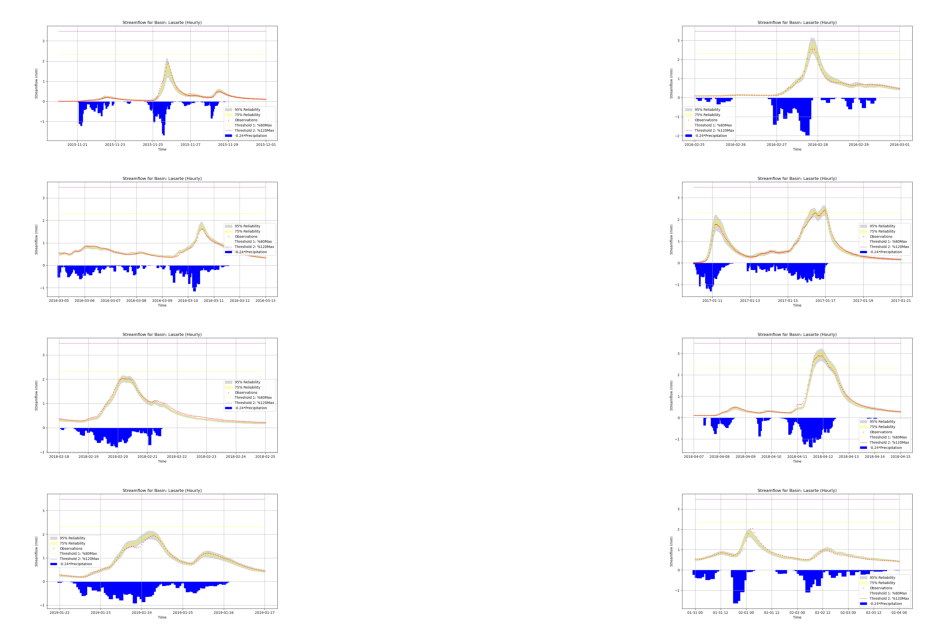

In [341]:
## Code to make plots combined for the paper

# Define the folder where the PNG files are located
folder_path = r'D:\Experiments\Final80TrainedModels\Plots\Lasarte\hourly'

# Get a list of all PNG files in the folder
png_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]

# Create a 2x4 grid of subplots with reduced spacing
fig, axes = plt.subplots(4, 2, figsize=(16, 8))

# Reduce spacing between subplots
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Loop through the PNG files and plot them in the grid
for i, file_name in enumerate(png_files):
    # Calculate the row and column index for the current subplot
    row = i // 2
    col = i % 2

    # Load and plot the current PNG file
    img = plt.imread(os.path.join(folder_path, file_name))
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks

# Save the combined plot with higher DPI for better quality
combined_plot_path = r'D:\Experiments\Final80TrainedModels\Plots\Lasarte\combined_hourly_plots.png'
plt.savefig(combined_plot_path, bbox_inches='tight', dpi=300)  # Adjust the DPI as needed

# Show the combined plot
plt.show()


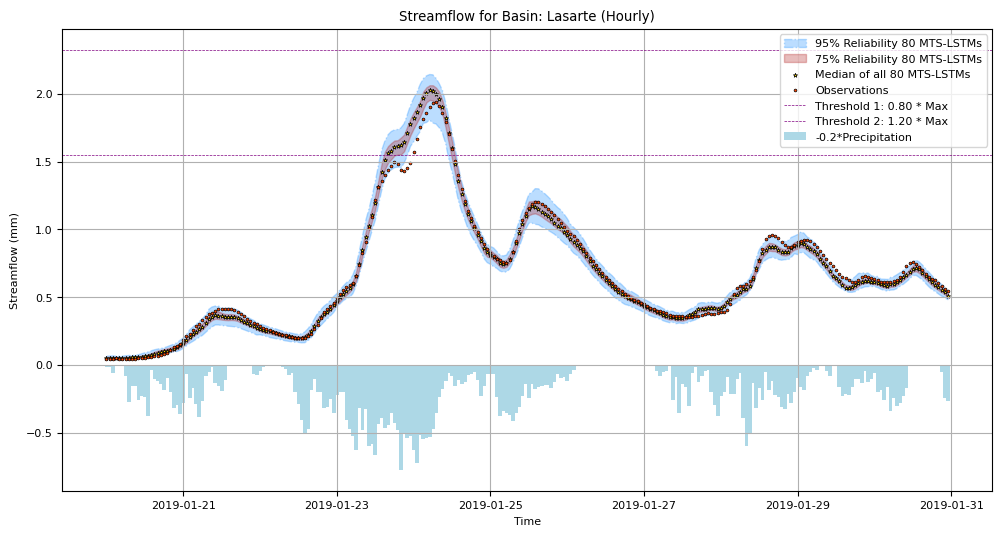

In [212]:
## To plot all final 80 models and CMAL samples 97% and 75% plots for hourly for Lasarte for a period

def plot_simulations(start_date_hr, end_date_hr, basin):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots\Lasarte'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')

    # Load hourly observation data
    obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_hourly.csv'))

    # Load hourly precipitation data
    prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

    # Load percentiles data (hourly)
    hourly_percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_50 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles50%', basin, 'hourly', f'{basin}_50%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
    hourly_percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()

    # Select a subset of the timestamp array within the specified date range
    mask = (obs_hourly_timestamp['timestamp'] >= start_date_hr) & (obs_hourly_timestamp['timestamp'] <= end_date_hr)
    timestamp_subset_hourly = obs_hourly_timestamp['timestamp'][mask].values

    # Create hourly plot (95% and 75% and 50% percentiles)

    plt.figure(figsize=(12, 6))

    # Define line styles for the threshold lines
    threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}


    # Use different grayscale colors for other lines
    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_5[mask], hourly_percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
    plt.fill_between(timestamp_subset_hourly, hourly_percentiles_25[mask], hourly_percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')

    plt.scatter(timestamp_subset_hourly, hourly_percentiles_50[mask], marker='*', color='gold', edgecolor='black', linewidths=0.5, label='Median of all 80 MTS-LSTMs', s=10)

    plt.scatter(timestamp_subset_hourly, obs_hourly[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
    plt.bar(timestamp_subset_hourly, -0.2 * prec_hourly[mask], color='lightblue', label='-0.2*Precipitation', width=0.05)
    plt.axhline((0.8 * np.max(obs_hourly[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
    plt.axhline((1.2 * np.max(obs_hourly[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

    plt.xlabel('Time')
    plt.ylabel('Streamflow (mm)')
    plt.title(f'Streamflow for Basin: {basin} (Hourly)')
    plt.legend(loc='upper right')  # Move the legend to the upper right corner
    plt.grid(True)

    # Save the hourly plot
    plt.savefig(
    os.path.join(os.path.join(output_folder, f'{basin}_hourly_plot.png')),
    dpi=300,  # Set the dpi value for high quality
    bbox_inches='tight'  # To ensure that the entire plot is saved
    )
    plt.show()

# Example usage
start_date_hr = '2019-01-20 00:00:00'
end_date_hr = '2019-01-30 23:00:00'
basin = 'Lasarte'

plot_simulations(start_date_hr, end_date_hr, basin)


In [ ]:
## Final Code for Plotting Water level simulations
## To plot all final 80 models and CMAL samples 97% and 75% plots

def plot_simulations(basin, durations, p = 0.2, plot_types=('hourly', 'daily')):
    # Define folder paths
    observation_folder = r'D:\Experiments\Observations\observations'
    output_folder = r'D:\Experiments\FinalPlots\Lasarte'
    precipitation_folder = r'D:\Experiments\Observations\precipitation'

    # Load observation timestamp data (hourly)
    obs_hourly_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_hr.csv'))
    obs_hourly_timestamp['timestamp'] = pd.to_datetime(obs_hourly_timestamp['date'], format='%m/%d/%Y %H:%M')
    obs_daily_timestamp = pd.read_csv(os.path.join(observation_folder, 'obs', 'date_day.csv'))
    obs_daily_timestamp['timestamp'] = pd.to_datetime(obs_daily_timestamp['date'], format='%d-%b-%y')

    for start_date, end_date in durations:
               
            obs_hourly = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_hourly.csv'))
            obs_daily = pd.read_csv(os.path.join(observation_folder, f'{basin}_qobs_mean_daily.csv')) * 24

            # Load hourly precipitation data
            prec_hourly = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_hourly.csv'))['precipitation']

            # Load daily precipitation data
            prec_daily = pd.read_csv(os.path.join(precipitation_folder, f'{basin}_prec_daily.csv'))['precipitation']

            for plot_type in plot_types:
                if plot_type == 'hourly':
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_hourly_timestamp['timestamp'] >= start_date) & (obs_hourly_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_hourly_timestamp['timestamp'][mask].values

                    obs = obs_hourly
                    prec = prec_hourly

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_95%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_75%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_50 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles50%', basin, 'hourly', f'{basin}_50%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'hourly', f'{basin}_5%qsim_mean_hourly.csv')).values.flatten()
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'hourly', f'{basin}_25%qsim_mean_hourly.csv')).values.flatten()

                    plot_title = f'Streamflow for Basin: {basin} (Hourly) - {start_date} to {end_date}'
                
                else:
                    # Select a subset of the timestamp array within the specified date range
                    mask = (obs_daily_timestamp['timestamp'] >= start_date) & (obs_daily_timestamp['timestamp'] <= end_date)
                    timestamp_subset = obs_daily_timestamp['timestamp'][mask].values

                    obs = obs_daily
                    prec = prec_daily

                    # Load the percentiles data for this specific basin and date range
                    percentiles_95 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_95%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_75 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_75%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_50 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles50%', basin, 'daily', f'{basin}_50%qsim_mean_daily.csv')).values.flatten()
                    percentiles_5 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles95%', basin, 'daily', f'{basin}_5%qsim_mean_daily.csv')).values.flatten() * 24
                    percentiles_25 = pd.read_csv(os.path.join(r'D:\Experiments\Final80TrainedModels\percentiles75%', basin, 'daily', f'{basin}_25%qsim_mean_daily.csv')).values.flatten() * 24

                    plot_title = f'Streamflow for Basin: {basin} (Daily) - {start_date} to {end_date}'
                
                # Now we create the plot in black and white

                # Define a threshold ratio based on the maximum values
                threshold_ratio = 0.5  # We can adjust this threshold as needed
                # Calculate the maximum values of precipitation and streamflow within the date range
                max_prec = np.max(prec[mask])
                max_obs = (np.max(obs[mask], axis=0)).item()

                # Conditionally adjust the scaling factor 'p'
                if (max_prec * p) / max_obs > threshold_ratio:
                    p_adjusted = 0.1  # Use a lower scaling factor
                    if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                        p_adjusted = 0.05  # Use a lower scaling factor
                        if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                            p_adjusted = 0.02  # Use a lower scaling factor
                            if (max_prec * p_adjusted) / max_obs > threshold_ratio:
                                p_adjusted = 0.01  # Use a lower scaling factor
                else:
                    p_adjusted = p  # Use the original scaling factor

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'black', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='darkgray', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='dimgray', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=1)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='black', label='Observations', s=3)

                plt.scatter(timestamp_subset, percentiles_50[mask], marker='*', color='gold', edgecolor='black', linewidths=0.5, label='Median of all 80 MTS-LSTMs', s=10)

                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='gray', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Water Level (m)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused', 'black', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_gray.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()

                # Now we create the colorful plot

                plt.figure(figsize=(12, 6))

                # Define line styles for the threshold lines
                threshold_style = {'color': 'purple', 'linewidth': 0.5, 'linestyle': '--'}

                # Use different grayscale colors for other lines
                plt.fill_between(timestamp_subset, percentiles_5[mask], percentiles_95[mask], color='dodgerblue', linestyle='-.', alpha=0.3, label='95% Reliability 80 MTS-LSTMs')
                plt.fill_between(timestamp_subset, percentiles_25[mask], percentiles_75[mask], color='firebrick', alpha=0.3, label='75% Reliability 80 MTS-LSTMs')
                if plot_type == 'hourly':
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=4)
                else:
                    plt.scatter(timestamp_subset, obs[mask], color='orangered', edgecolor='black', linewidths=0.5, label='Observations', s=7)

                plt.scatter(timestamp_subset, percentiles_50[mask], marker='*', color='gold', edgecolor='black', linewidths=0.5, label='Median of all 80 MTS-LSTMs', s=10)

                plt.bar(timestamp_subset, -p_adjusted * prec[mask], color='lightblue', label=f'-{p_adjusted}*Precipitation', width=0.05)
                plt.axhline((0.8 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 1: 0.80 * Max')
                plt.axhline((1.2 * np.max(obs[mask], axis=0)).item(), **threshold_style, label='Threshold 2: 1.20 * Max')

                # Add a clear line for y=0
                plt.axhline(0, color='black', linewidth=0.7, linestyle='-')

                plt.xlabel('Time')
                plt.ylabel('Streamflow (mm)')
                plt.title(plot_title)
                plt.tight_layout()
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
                plt.grid(True)

                # Save the plot
                plot_folder = os.path.join(output_folder, 'focused', 'color', plot_type)
                os.makedirs(plot_folder, exist_ok=True)
                plt.savefig(
                os.path.join(os.path.join(plot_folder, f'{basin}_{plot_type}_{start_date}-{end_date}_plot_color.png')),
                dpi=300,  # Set the dpi value for high quality
                bbox_inches='tight'  # To ensure that the entire plot is saved
                )
                plt.close()


In [ ]:
basins = [
('Lasarte', [
    ('2015-11-21', '2015-11-30'),
    ('2016-02-26', '2016-03-01'),
    ('2016-03-09', '2016-03-13'),
    ('2017-01-08', '2017-01-22'),
    ('2018-02-18', '2018-02-22'),
    ('2018-04-10', '2018-04-15'),
    ('2019-01-22', '2019-02-05'),
    ('2019-12-11', '2019-12-17'),
    ('2020-10-10', '2020-10-19')
])]

# Loop through basins and their durations
for basin_name, durations in basins:
    plot_simulations(basin_name, durations)


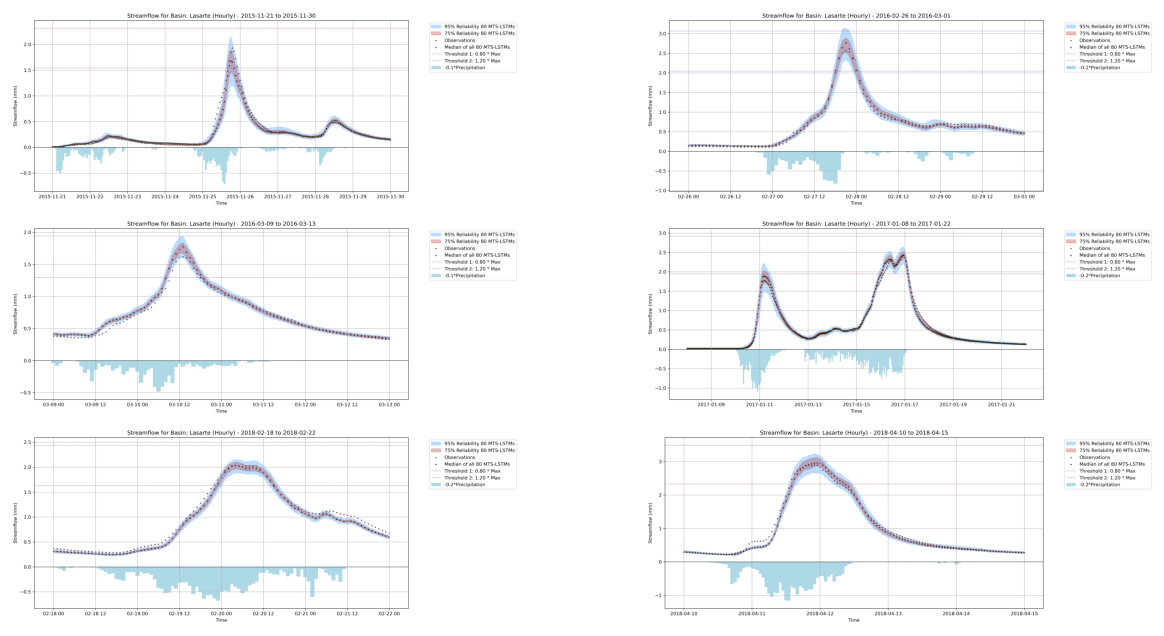

In [214]:
## Code to make plots combined for the paper

# Define the folder where the PNG files are located
folder_path = r'D:\Experiments\FinalPlots\Lasarte\focused\color\hourly'

# Get a list of all PNG files in the folder
png_files = [file for file in os.listdir(folder_path) if file.endswith('.png')]

# Create a 2x4 grid of subplots with reduced spacing
fig, axes = plt.subplots(3, 2, figsize=(16, 8))

# Reduce spacing between subplots
plt.subplots_adjust(hspace=0.05, wspace=0.05)

# Loop through the PNG files and plot them in the grid
for i, file_name in enumerate(png_files):
    # Calculate the row and column index for the current subplot
    row = i // 2
    col = i % 2

    # Load and plot the current PNG file
    img = plt.imread(os.path.join(folder_path, file_name))
    axes[row, col].imshow(img)
    axes[row, col].axis('off')  # Turn off axis labels and ticks

# Save the combined plot with higher DPI for better quality
combined_plot_path = r'D:\Experiments\FinalPlots\Lasarte\focused\color\hourly\combined_hourly_plots.tiff'
plt.savefig(combined_plot_path, bbox_inches='tight', dpi=600)  # Adjust the DPI as needed

# Show the combined plot
plt.show()


In [ ]:
import graphviz

# Create a Graph object
flowchart = graphviz.Digraph('Methodology', format='png')

# Add nodes for each step in your methodology
flowchart.node('Data Collection and Preprocessing')
flowchart.node('Neural-Hydrology Library and Model Selection')
flowchart.node('Hyperparameter Tuning')
flowchart.node('Data Splitting Approach')
flowchart.node('Hyperparameter Sensitivity Analysis')
flowchart.node('Hyperparameter Optimization')
flowchart.node('The Final Train/Test Analysis')
flowchart.node('Evaluation Metrics')
flowchart.node('Summary and Implications')

# Add edges to connect the steps
flowchart.edges([
    ('Data Collection and Preprocessing', 'Neural-Hydrology Library and Model Selection'),
    ('Neural-Hydrology Library and Model Selection', 'Hyperparameter Tuning'),
    ('Hyperparameter Tuning', 'Data Splitting Approach'),
    ('Data Splitting Approach', 'Hyperparameter Sensitivity Analysis'),
    ('Hyperparameter Sensitivity Analysis', 'Hyperparameter Optimization'),
    ('Hyperparameter Optimization', 'The Final Train/Test Analysis'),
    ('The Final Train/Test Analysis', 'Evaluation Metrics'),
    ('Evaluation Metrics', 'Summary and Implications')
])

# Render the flowchart as a PNG file
flowchart.render('methodology')


import graphviz
import os  # Import the os module

# Define your flowchart using the Graphviz library
dot = graphviz.Digraph(comment='Methodology Flowchart')

# Add nodes and edges to your flowchart
# (Your code for building the flowchart)

# Render and save the flowchart as an image
image_path = 'methodology.png'  # Specify the image filename
dot.render(image_path, view=False)  # Use 'view=False' to avoid opening the image

# Get the current working directory
current_directory = os.getcwd()

# Combine the current directory and image path to get the full file path
full_image_path = os.path.join(current_directory, image_path)

# Print the full path to the generated image
print(f"Flowchart image saved at: {full_image_path}")

